In [1]:
import sys
import os
sys.path.append("../src/")
import combat
import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sb
import pickle as pkl
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
from sklearn.preprocessing import quantile_transform,binarize
from sklearn.model_selection import LeaveOneOut,KFold
from sklearn.metrics import r2_score
from statsmodels.stats.multitest import multipletests
from sklearn.cross_decomposition import PLSRegression as PLS
import warnings
warnings.simplefilter("ignore")
from multiprocessing import Process,Queue,Pool
import time 
import helper
from multiprocessing import set_start_method
#set_start_method("spawn")
from DecoID.DecoID import flatten
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
import helper


In [2]:
results = pkl.load(open("modeling_results_all.pkl","rb"))
#print(results)
results = results[results["Score"] < results["Training Score"]]
#results = results[results["Score"] > results["Training Score"] * 2/3]
bestParams = results[results["Score"] == results["Score"].max()]
ind = bestParams.index.values[0]
print(bestParams)
print(bestParams.at[ind,"Params"])
baseline = bestParams.at[ind,"Baseline"]
params = bestParams.at[ind,"Params"]
model = bestParams.at[ind,"Model"]
model_names = ["Logistic Regression","ElasticNet","PLSDA","SVM","Random Forest"]
model_train_funcs = [helper.trainLogisticRegression,helper.trainElasticNet,helper.trainPLSDA,helper.trainSVM,helper.trainRF]
model_predict_funcs = [helper.predictLogisticRegression,helper.predictElasticNet,helper.predictPLSDA,helper.predictSVM,helper.predictRF]
train_mapping = {name:func for name,func in zip(model_names,model_train_funcs)}
predict_mapping = {name:func for name,func in zip(model_names,model_predict_funcs)}

trainFunc,predictFunc = train_mapping[model],predict_mapping[model]


   Model                                             Params Baseline  \
2  PLSDA  {'feat_selection': ('corr', 0.2222222222222222...     none   
7  PLSDA  {'feat_selection': ('corr', 0.2222222222222222...      all   

      Score  Training Score  
2  0.563437             1.0  
7  0.563437             1.0  
{'feat_selection': ('corr', 0.2222222222222222), 'n_components': 5}


In [3]:
#load in metadata and peak areas and associate

#read in peak data
datafilename = "../data/08_10_2020_batch_1_6_polar_non_polar_id_unk_peak_areas.csv"
data = pd.read_csv(datafilename)

#get area columns
areaCols = data.columns.values[5:]

#get molecule names
mol_names = data["Compound Name"].values

#extract area data and transpose
areaData = data[areaCols].transpose()

#get batch information
batchInfo = [int(x.split("_")[0][1]) for x in list(areaData.index.values)]

areaData = areaData.to_numpy()
areaData = areaData.astype(np.float)

#get index of blanks
blankSamp = [x for x in range(len(areaCols)) if "Blank" in areaCols[x] and not "equil" in areaCols[x]]
print(len(blankSamp)," blanks")

#get index of qc
qcSamp = [x for x in range(len(areaCols)) if "NIST" in areaCols[x] and not "equil" in areaCols[x] ]
print(len(qcSamp)," qc samples")

#get index of wu350 samples
samp = [x for x in range(len(areaCols)) if "WU350" in areaCols[x] and not "equil" in areaCols[x]]
print(len(samp), "research samples")

#load in metadata
metadatafn = "../data/07_30_2020_batch_1_6_qTOF_polar_non_polar_experiment_parameters.csv"
metadata = pd.read_csv(metadatafn)

#extact sample names for d0_yes samples
metadata_rel = metadata[metadata["day-COVID"] == "d0_Yes"]
print(len(metadata_rel)," d0 Covid+ Samples")

metadata_val = metadata[metadata["day-COVID"] == "d0_No"]
print(len(metadata_val), "d0 Covid- Samples")

val_samples = []
for index,row in metadata_val.iterrows():
    val_samples.append(row["Sample General Name"])
    
val_cols = []
for val_s in val_samples:
    for col in range(len(areaCols)):
        if areaCols[col] == val_s:
            val_cols.append(col)
            break

            
#create sample name, ventilator status linkage
vent_dict = {}
for index,row in metadata_rel.iterrows():
    val = str(row["Epic: Subject on ventilation at any point after biospecimen sample 1"])
    sampName = row["Sample General Name"]
    if "es" in val:
        val = 1
    elif "o" in val:
        val = 0
    vent_dict[sampName] = val

print(np.sum(list(vent_dict.values()))," vent+ samples")
print(len(vent_dict) - np.sum(list(vent_dict.values()))," vent- samples")

#link vent status to sample in peak data
vent_status = []
for s in np.array(areaCols)[samp]:
    tmp = s
    if tmp in vent_dict:
        vent_status.append(vent_dict[tmp])
    else:
        vent_status.append(-1)

print("found vent info for",len([x for x in vent_status if x != -1]),"covid_ d0 samples")
samplesOfInterest = [x for x in range(len(vent_status)) if vent_status[x] != -1]

val_int = areaData[val_cols]
val_batch = np.array(batchInfo)[val_cols]
val_vent = np.array([0 for _ in val_batch])

#create sample matrix
samp_batch = np.array(batchInfo)[samp][samplesOfInterest]
samp_int = areaData[samp][samplesOfInterest]
samp_vent = np.array(vent_status)[samplesOfInterest]

#create blank matrix
blank_batch = np.array(batchInfo)[blankSamp]
blank_int = areaData[blankSamp]

#create qc matrix
qc_batch = np.array(batchInfo)[qcSamp]
qc_int = areaData[qcSamp]

0  blanks
0  qc samples
530 research samples
168  d0 Covid+ Samples
35 d0 Covid- Samples
31  vent+ samples
137  vent- samples
found vent info for 168 covid_ d0 samples


No handles with labels found to put in legend.


Text(0, 0.5, 'PC2')

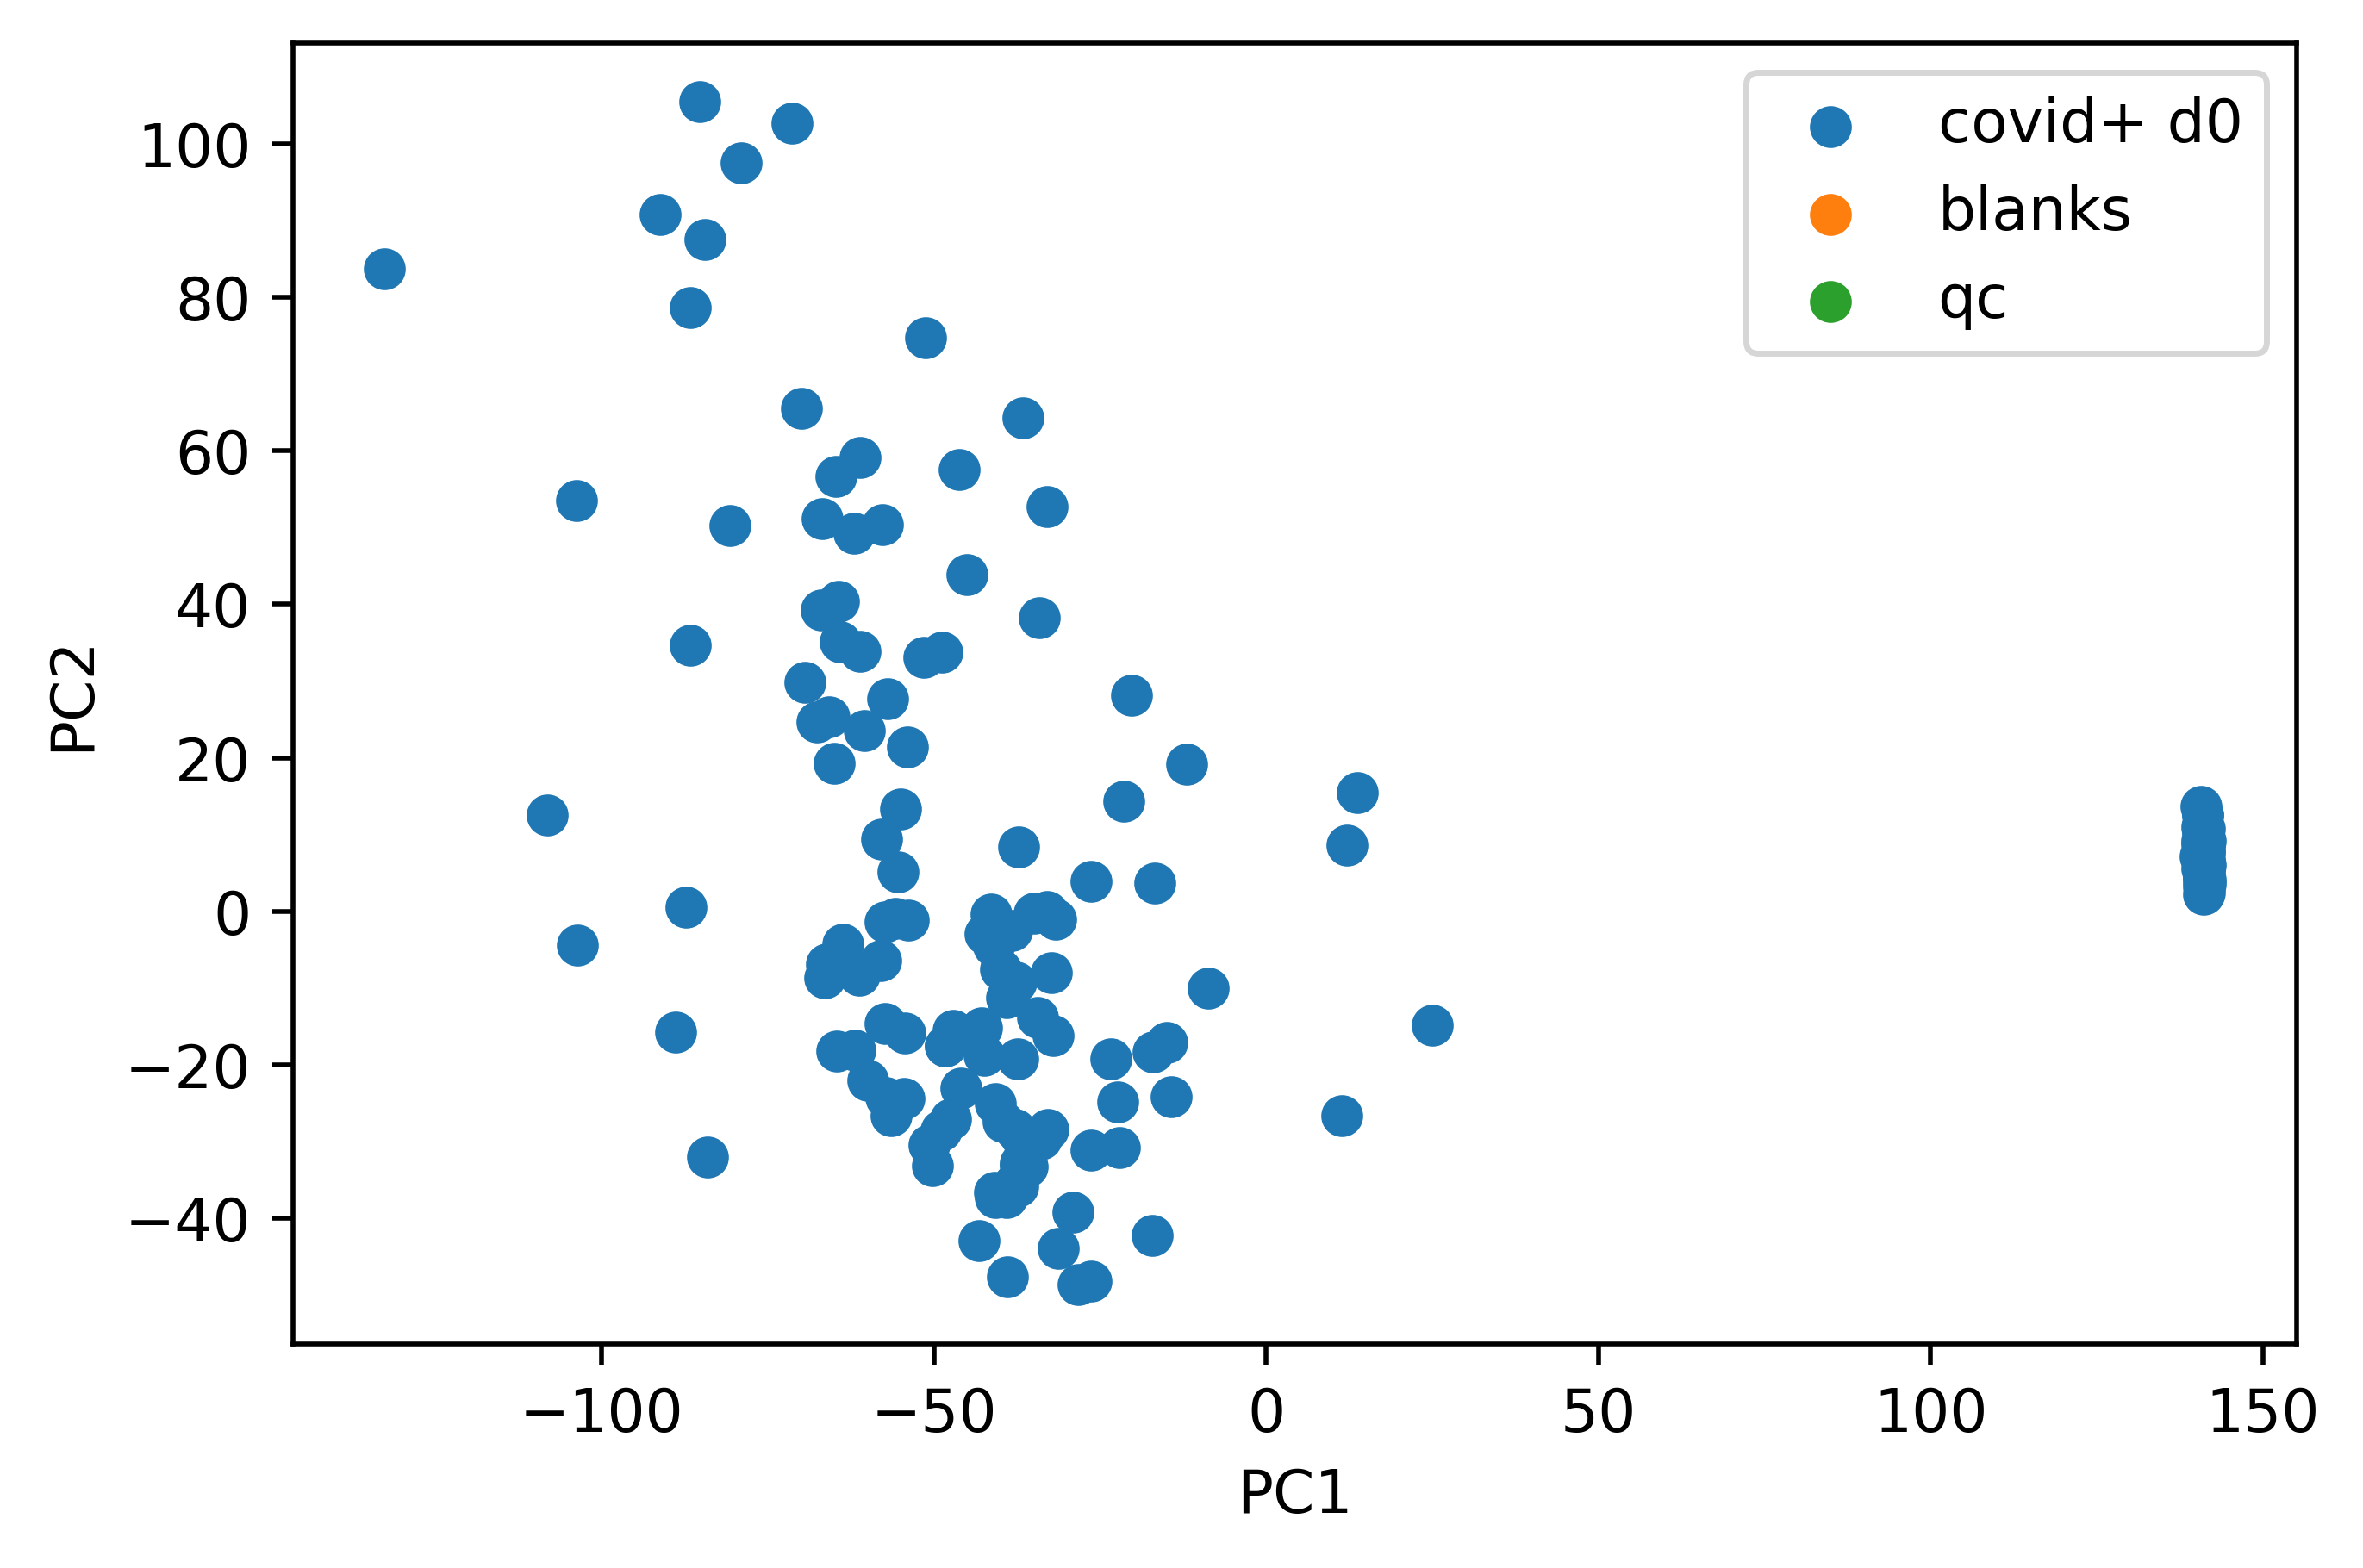

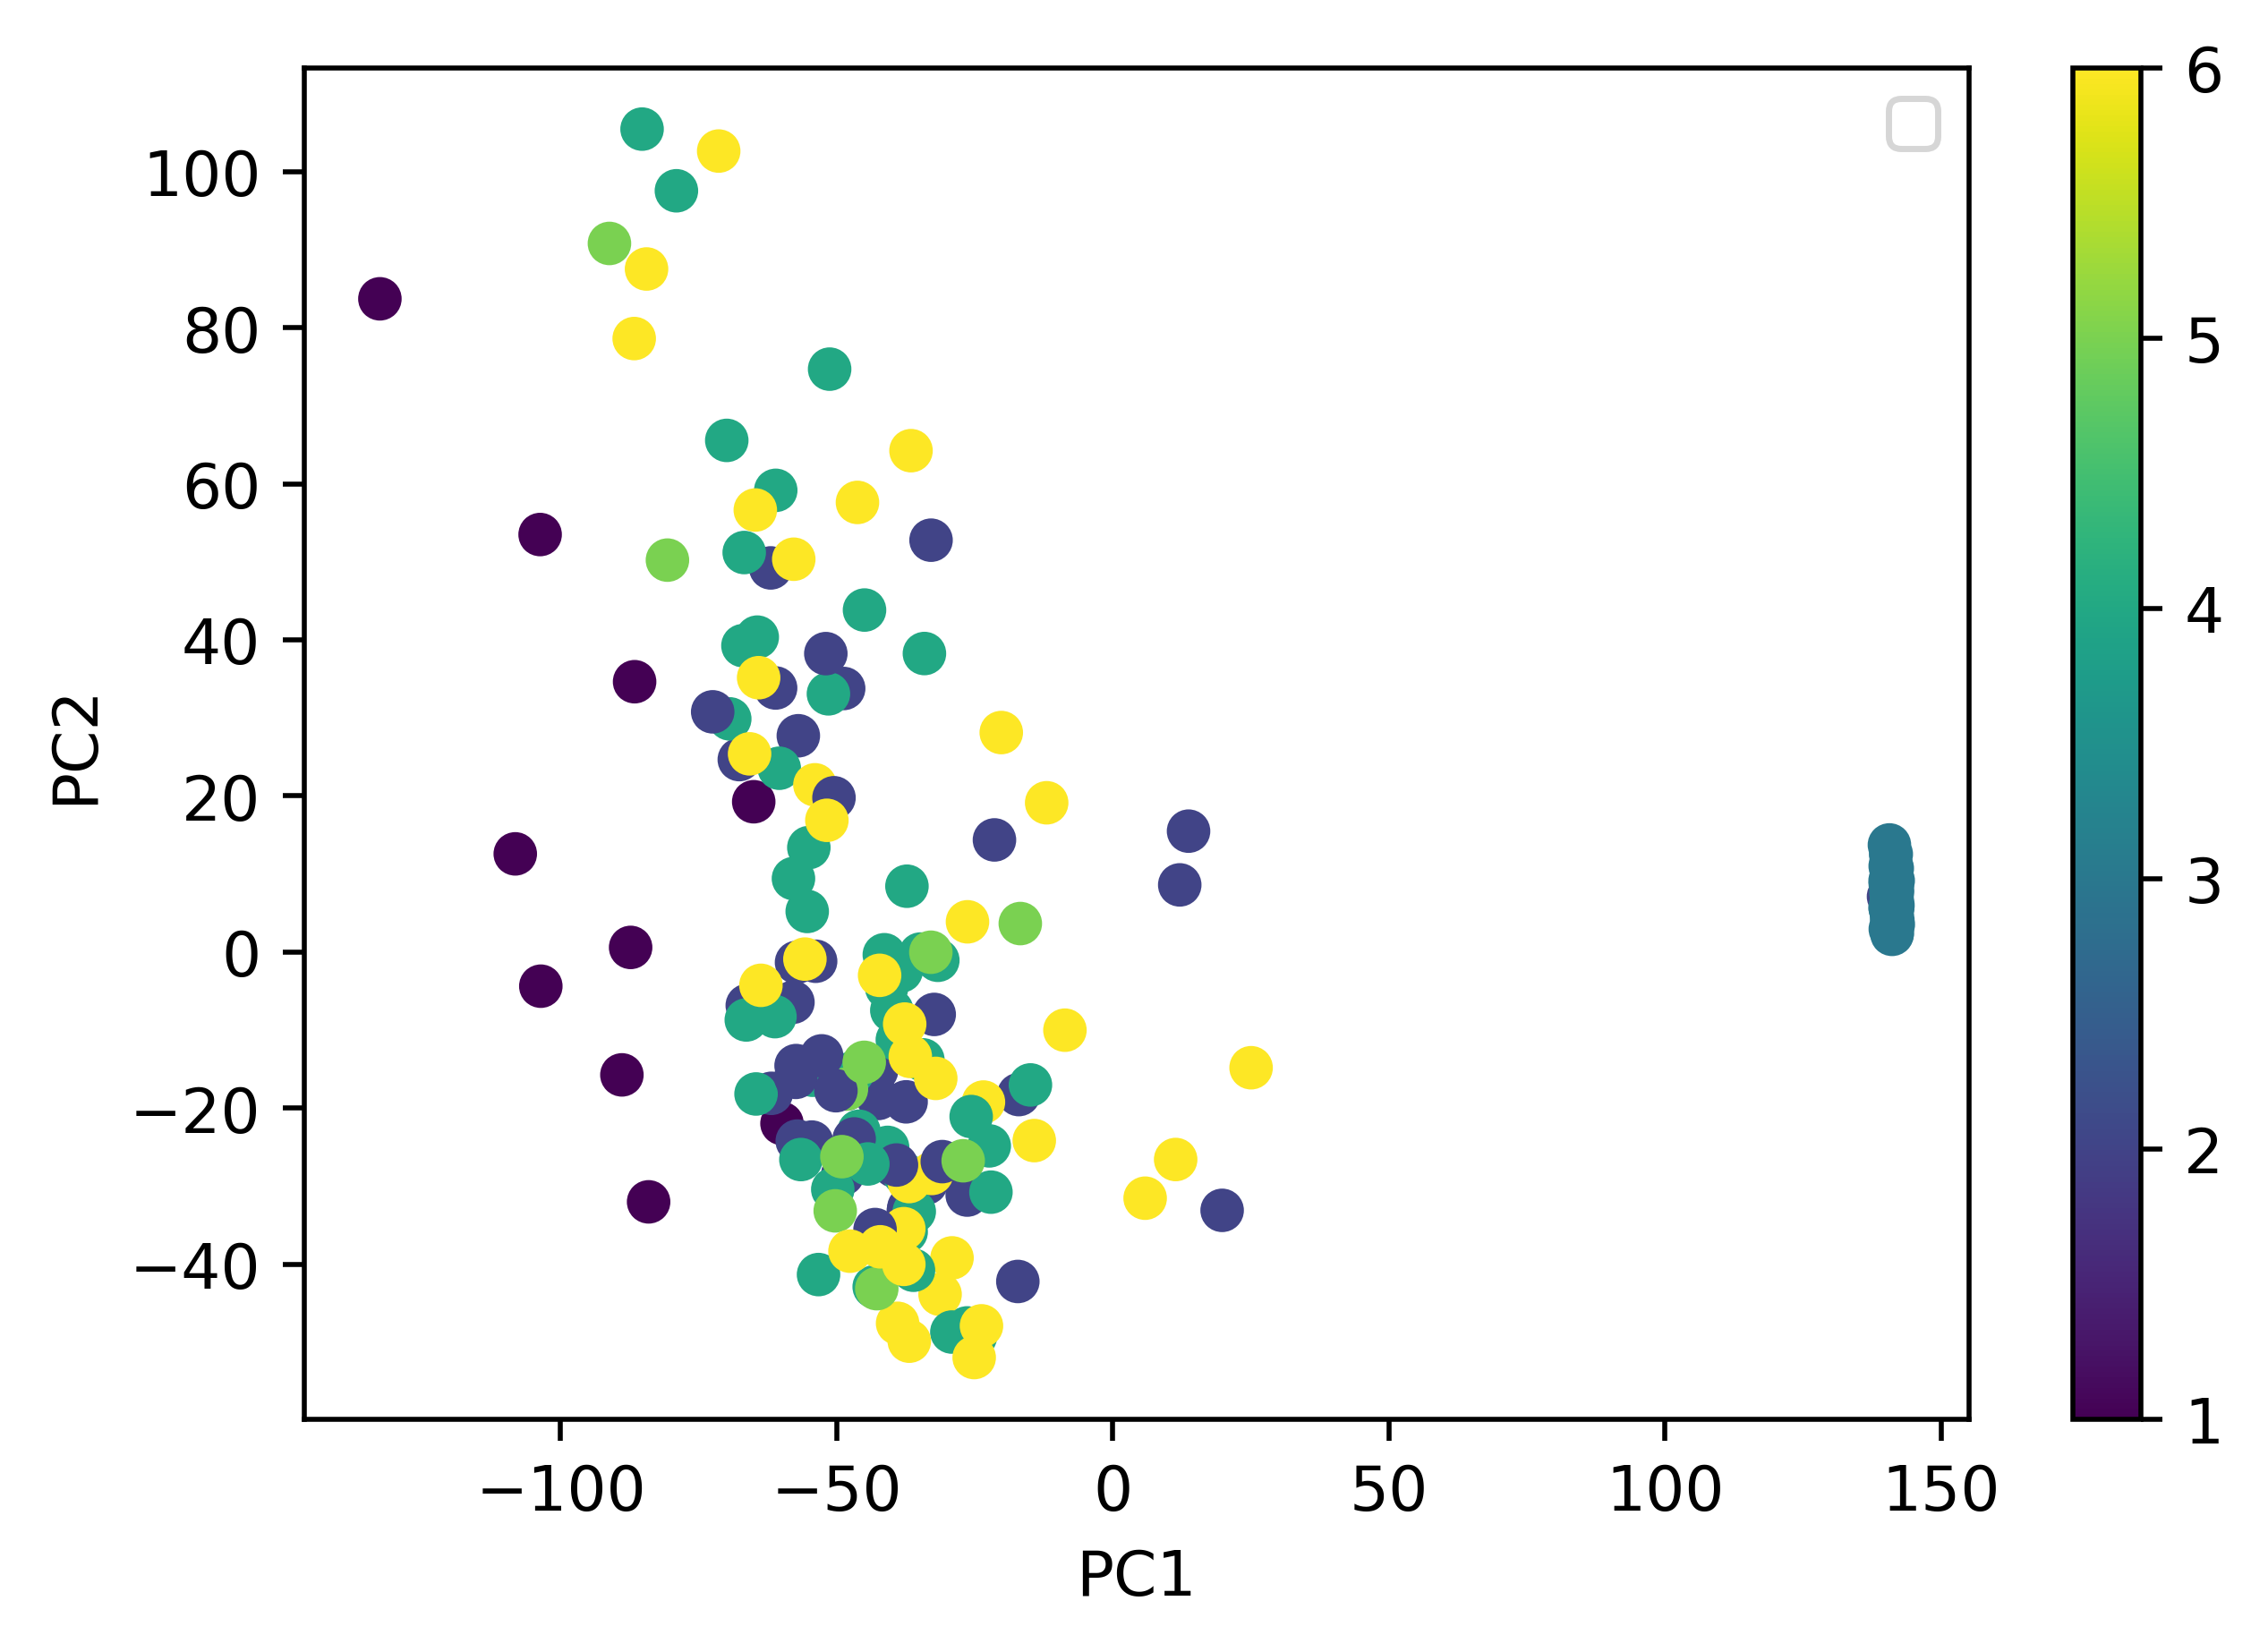

In [4]:
#visualize complete dataset

#first impute dataset
d_whole = np.concatenate((samp_int,blank_int,qc_int,val_int))
d_whole_imput = helper.imputeRowMin(d_whole)

#log2 normalize
d_whole_imput = np.log2(d_whole_imput) 

#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_imput)
loads = pca.transform(d_whole_imput)

samp_load = loads[:len(samp_int)]
blank_load = loads[len(samp_int):len(samp_int)+len(blank_int)]
qc_load = loads[len(samp_int)+len(blank_int):len(samp_int)+len(blank_int)+len(qc_int)]

#make pca plot divided by sample type
plt.scatter(samp_load[:,0],samp_load[:,1],label="covid+ d0")
plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#make pca plot by batch
plt.figure()
batch_con = np.concatenate((samp_batch,blank_batch,qc_batch,val_batch))
plt.scatter(loads[:,0],loads[:,1],c=batch_con)
plt.colorbar()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")


found 6 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments
No handles with labels found to put in legend.


Adjusting data


Text(0, 0.5, 'PC2')

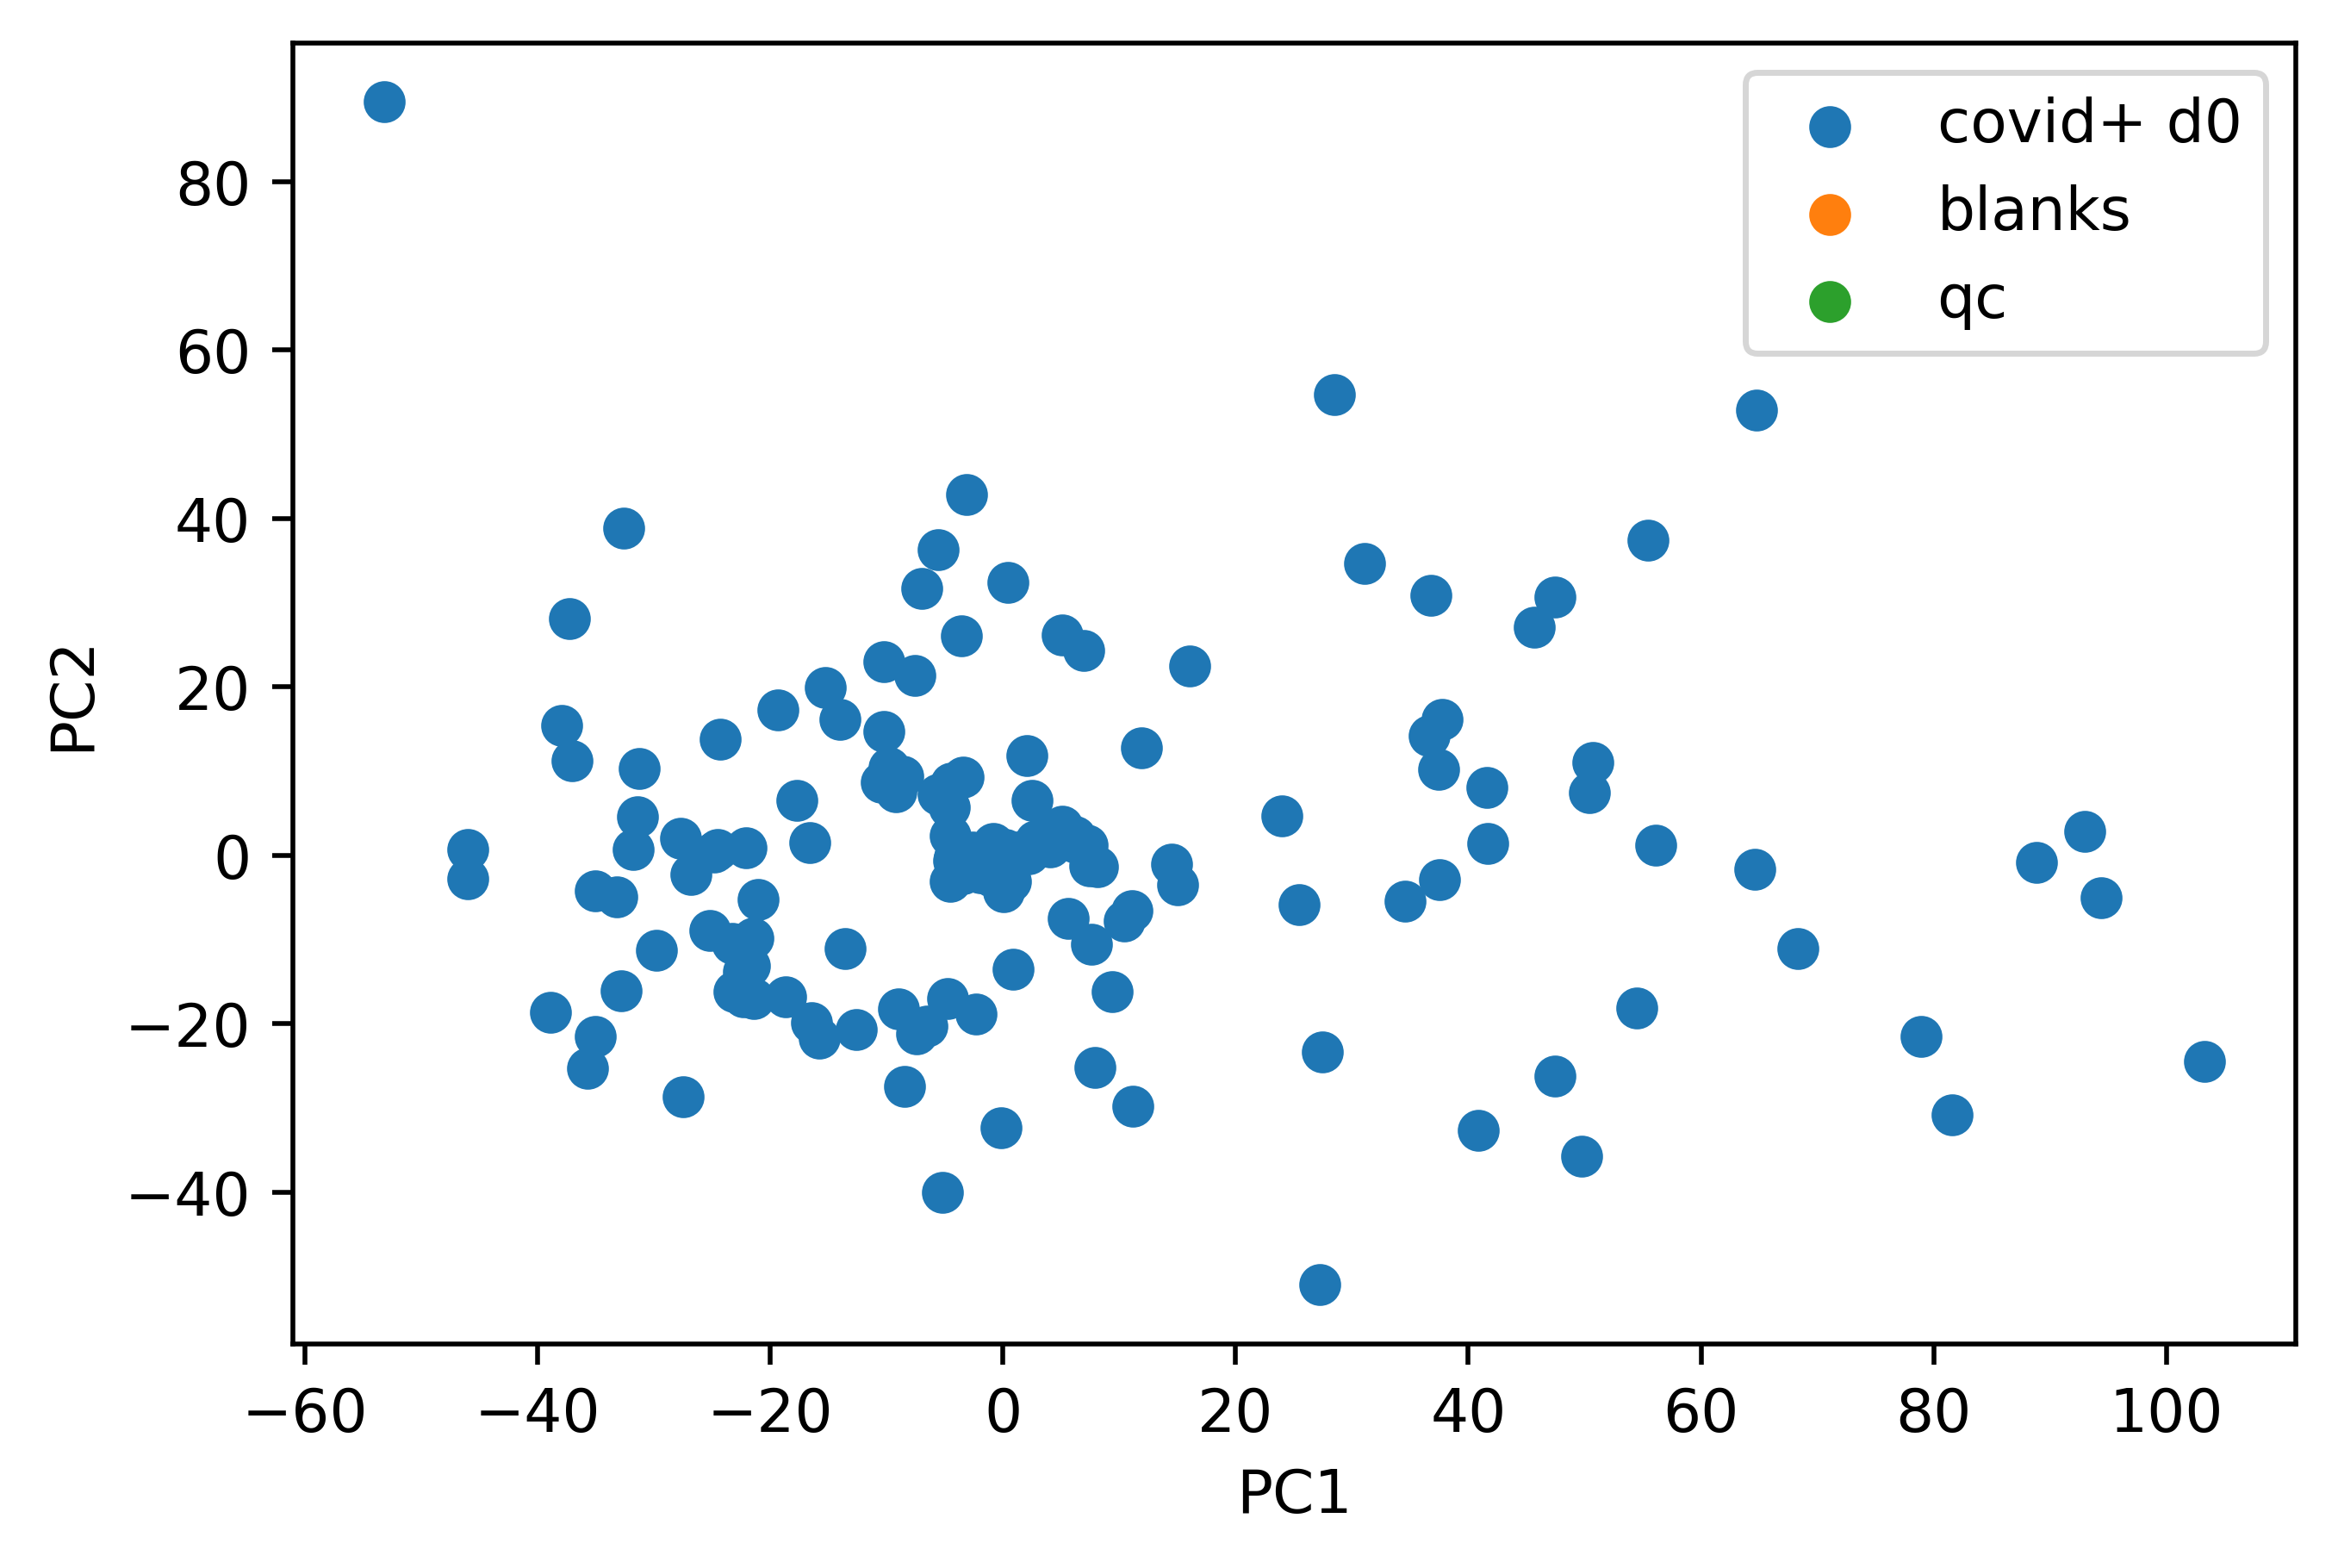

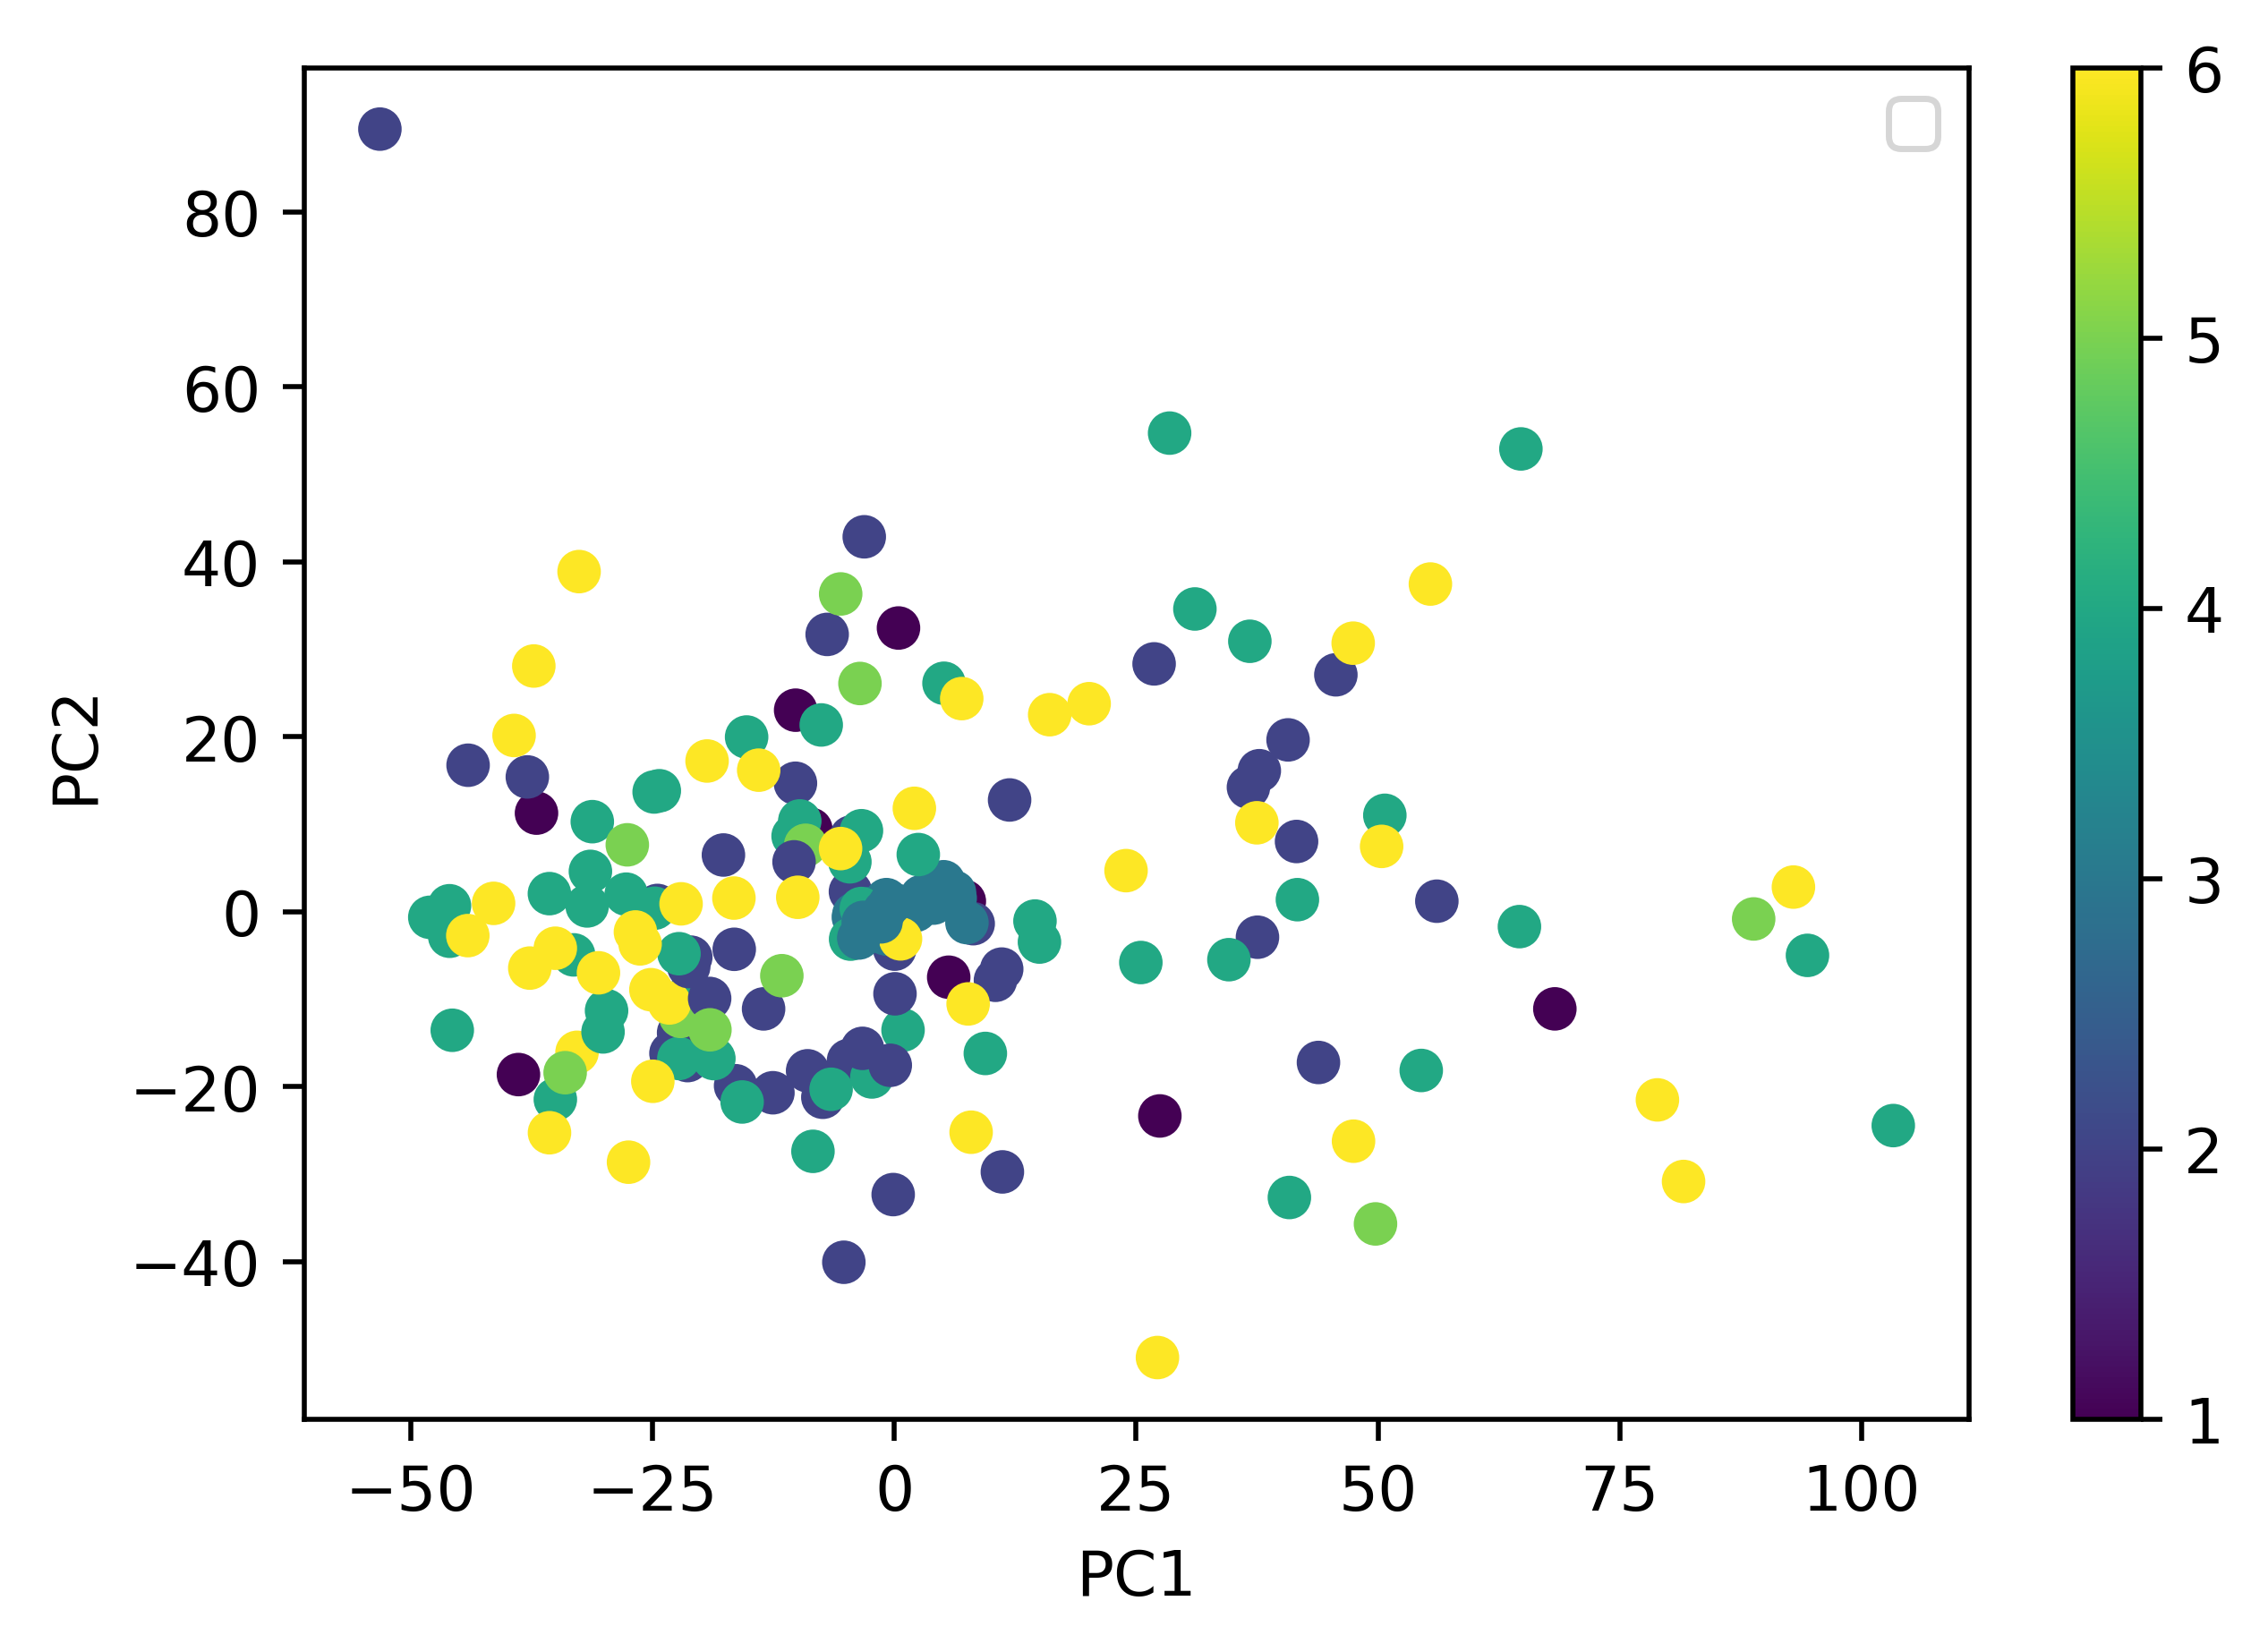

In [5]:
#now quantile normalize

d_whole_norm = combat.combat(pd.DataFrame(d_whole_imput.transpose()),np.concatenate((samp_batch,blank_batch,qc_batch,val_batch))).transpose().to_numpy()


#baseline

if baseline == "qc":
    # #baseline to qcSamps
    baseInt = [np.median(x) for x in d_whole_norm[len(samp_int) + len(blank_int):].transpose()]
    d_whole_norm = np.array([[v - med for v, med in zip(row, baseInt)] for row in d_whole_norm])

if baseline == "all":
    baseInt = [np.median(x) for x in d_whole_norm.transpose()]
    d_whole_norm = np.array([[v - med for v, med in zip(row, baseInt)] for row in d_whole_norm])




#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_norm)
loads = pca.transform(d_whole_norm)

samp_load = loads[:len(samp_int)]
blank_load = loads[len(samp_int):len(samp_int)+len(blank_int)]
qc_load = loads[len(samp_int)+len(blank_int):len(samp_int)+len(blank_int)+len(qc_int)]

#make pca plot divided by sample type
plt.scatter(samp_load[:,0],samp_load[:,1],label="covid+ d0")
plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#make pca plot by batch
plt.figure()
batch_con = np.concatenate((samp_batch,blank_batch,qc_batch,val_batch))
plt.scatter(loads[:,0],loads[:,1],c=batch_con)
plt.colorbar()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")



Text(0, 0.5, 'PC2')

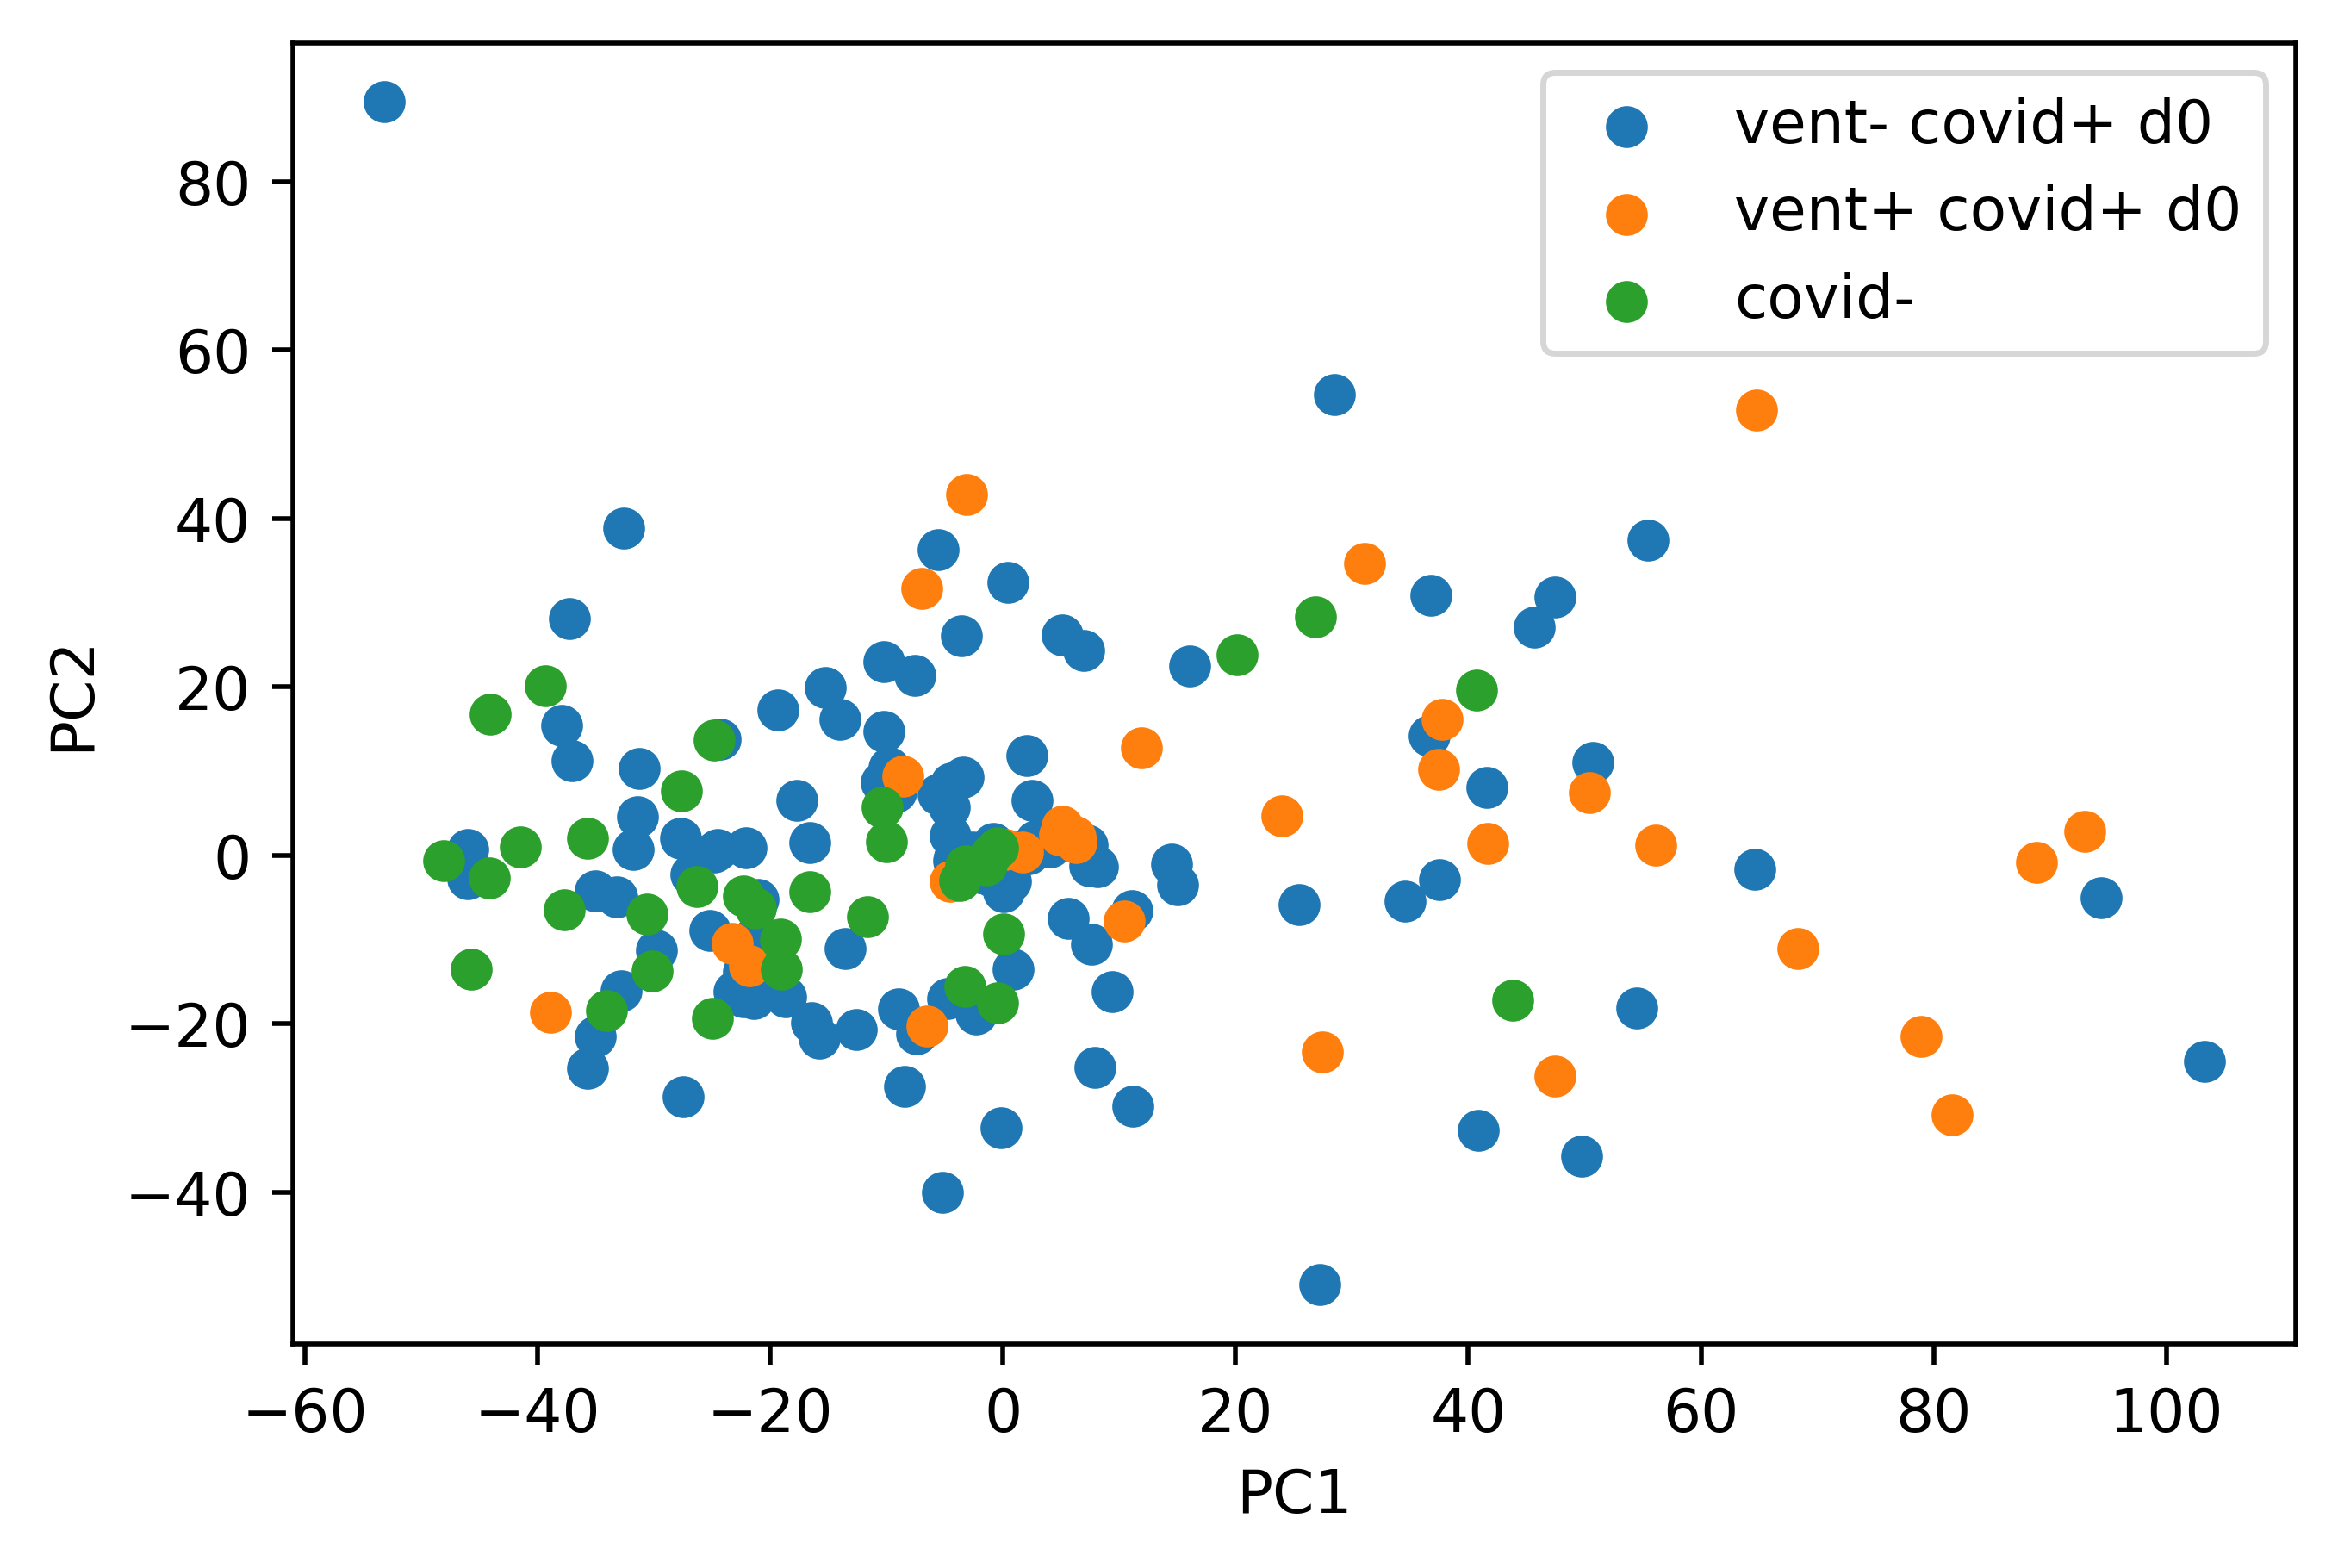

In [6]:
#now plot research samples by vent status
#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_norm)
loads = pca.transform(d_whole_norm)

#get vent pos/neg loadings
negSamples = [x for x in range(len(samp_vent)) if samp_vent[x] == 0]
posSamples = [x for x in range(len(samp_vent)) if samp_vent[x] == 1]
samp_load_vent_neg = loads[:len(samp_int)][negSamples]
samp_load_vent_pos = loads[:len(samp_int)][posSamples]

#get blanks and qc
blank_load = loads[len(samp_int):len(samp_int)+len(blank_int)]
qc_load = loads[len(samp_int)+len(blank_int):len(samp_int)+len(blank_int)+len(qc_int)]
val_load = loads[len(samp_int)+len(blank_int)+len(qc_int):]

#make pca plot divided by sample type
plt.scatter(samp_load_vent_neg[:,0],samp_load_vent_neg[:,1],label="vent- covid+ d0")
plt.scatter(samp_load_vent_pos[:,0],samp_load_vent_pos[:,1],label="vent+ covid+ d0")
#plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
#plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.scatter(val_load[:,0],val_load[:,1],label="covid-")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")



In [7]:
#create train and test sets for prediction model

#train batches on 1-4
#test on 5-6

trainBatches = [1,2,3,4]
testBatches = [5,6]


#get blanks for train/test
blank_train_index = [x for x in range(len(blank_batch)) if blank_batch[x] in trainBatches]
blank_test_index = [x for x in range(len(blank_batch)) if blank_batch[x] in testBatches]

blank_train_int = blank_int[blank_train_index]
blank_test_int = blank_int[blank_test_index]

blank_train_batch = blank_batch[blank_train_index]
blank_test_batch = blank_batch[blank_test_index]

#get samples for train/test
samp_train_index = [x for x in range(len(samp_batch)) if samp_batch[x] in trainBatches]
samp_test_index = [x for x in range(len(samp_batch)) if samp_batch[x] in testBatches]

samp_train_int = samp_int[samp_train_index]
samp_test_int = samp_int[samp_test_index]

samp_train_vent = samp_vent[samp_train_index]
samp_test_vent = samp_vent[samp_test_index]

samp_train_batch = samp_batch[samp_train_index]
samp_test_batch = samp_batch[samp_test_index]

#get qc for train/test

qc_train_index = [x for x in range(len(qc_batch)) if qc_batch[x] in trainBatches]
qc_test_index = [x for x in range(len(qc_batch)) if qc_batch[x] in testBatches]

qc_train_int = qc_int[qc_train_index]
qc_test_int = qc_int[qc_test_index] 

qc_train_batch = qc_batch[qc_train_index]
qc_test_batch = qc_batch[qc_test_index] 

#need to add vent and qcs

print("training examples: ",len(samp_train_int),"testing examples: ",len(samp_test_int))
print("training vent+ examples:, ",len([x for x in samp_train_vent if x == 1]),
      "training vent- examples:, ",len([x for x in samp_train_vent if x == 0]))
print("testing vent+ examples:, ",len([x for x in samp_test_vent if x == 1]),
      "testing vent- examples:, ",len([x for x in samp_test_vent if x == 0]))

training examples:  132 testing examples:  36
training vent+ examples:,  22 training vent- examples:,  110
testing vent+ examples:,  9 testing vent- examples:,  27


In [8]:
X_train,y_train,X_test,y_test,X_train_blank = helper.normalize_data(samp_train_int,blank_train_int,qc_train_int,np.concatenate((samp_test_int,val_int)), blank_test_int, qc_test_int,samp_train_batch,
                           blank_train_batch, qc_train_batch, np.concatenate((samp_test_batch,val_batch)), blank_test_batch, qc_test_batch,samp_train_vent,np.concatenate((samp_test_vent,val_vent)),baseline)
X_test,X_val = X_test[:len(samp_test_batch)],X_test[len(samp_test_batch):]
y_test,y_val = y_test[:len(samp_test_batch)],y_test[len(samp_test_batch):]

found 6 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data


training score:  0.9999999999999998
0.17054263565891473 1.0 -0.20915406040182274
0.1640625 0.9545454545454546 -0.19960329643400943
0.16535433070866143 0.9545454545454546 -0.18589973834555984
0.16666666666666666 0.9545454545454546 -0.17592521570809458
0.16 0.9090909090909091 -0.1749874464621811
0.16129032258064516 0.9090909090909091 -0.17332723342411643
0.16260162601626016 0.9090909090909091 -0.1725429404210027
0.16393442622950818 0.9090909090909091 -0.16632132826486393
0.1652892561983471 0.9090909090909091 -0.16221833566144048
0.16666666666666666 0.9090909090909091 -0.16090508647291826
0.16806722689075632 0.9090909090909091 -0.15224655900813042
0.1694915254237288 0.9090909090909091 -0.14933989803598216
0.17094017094017094 0.9090909090909091 -0.14577560209523363
0.16379310344827586 0.8636363636363636 -0.11470741882813357
0.16521739130434782 0.8636363636363636 -0.11177436007015615
0.16666666666666666 0.8636363636363636 -0.10980085880896234
0.168141592920354 0.8636363636363636 -0.10973540

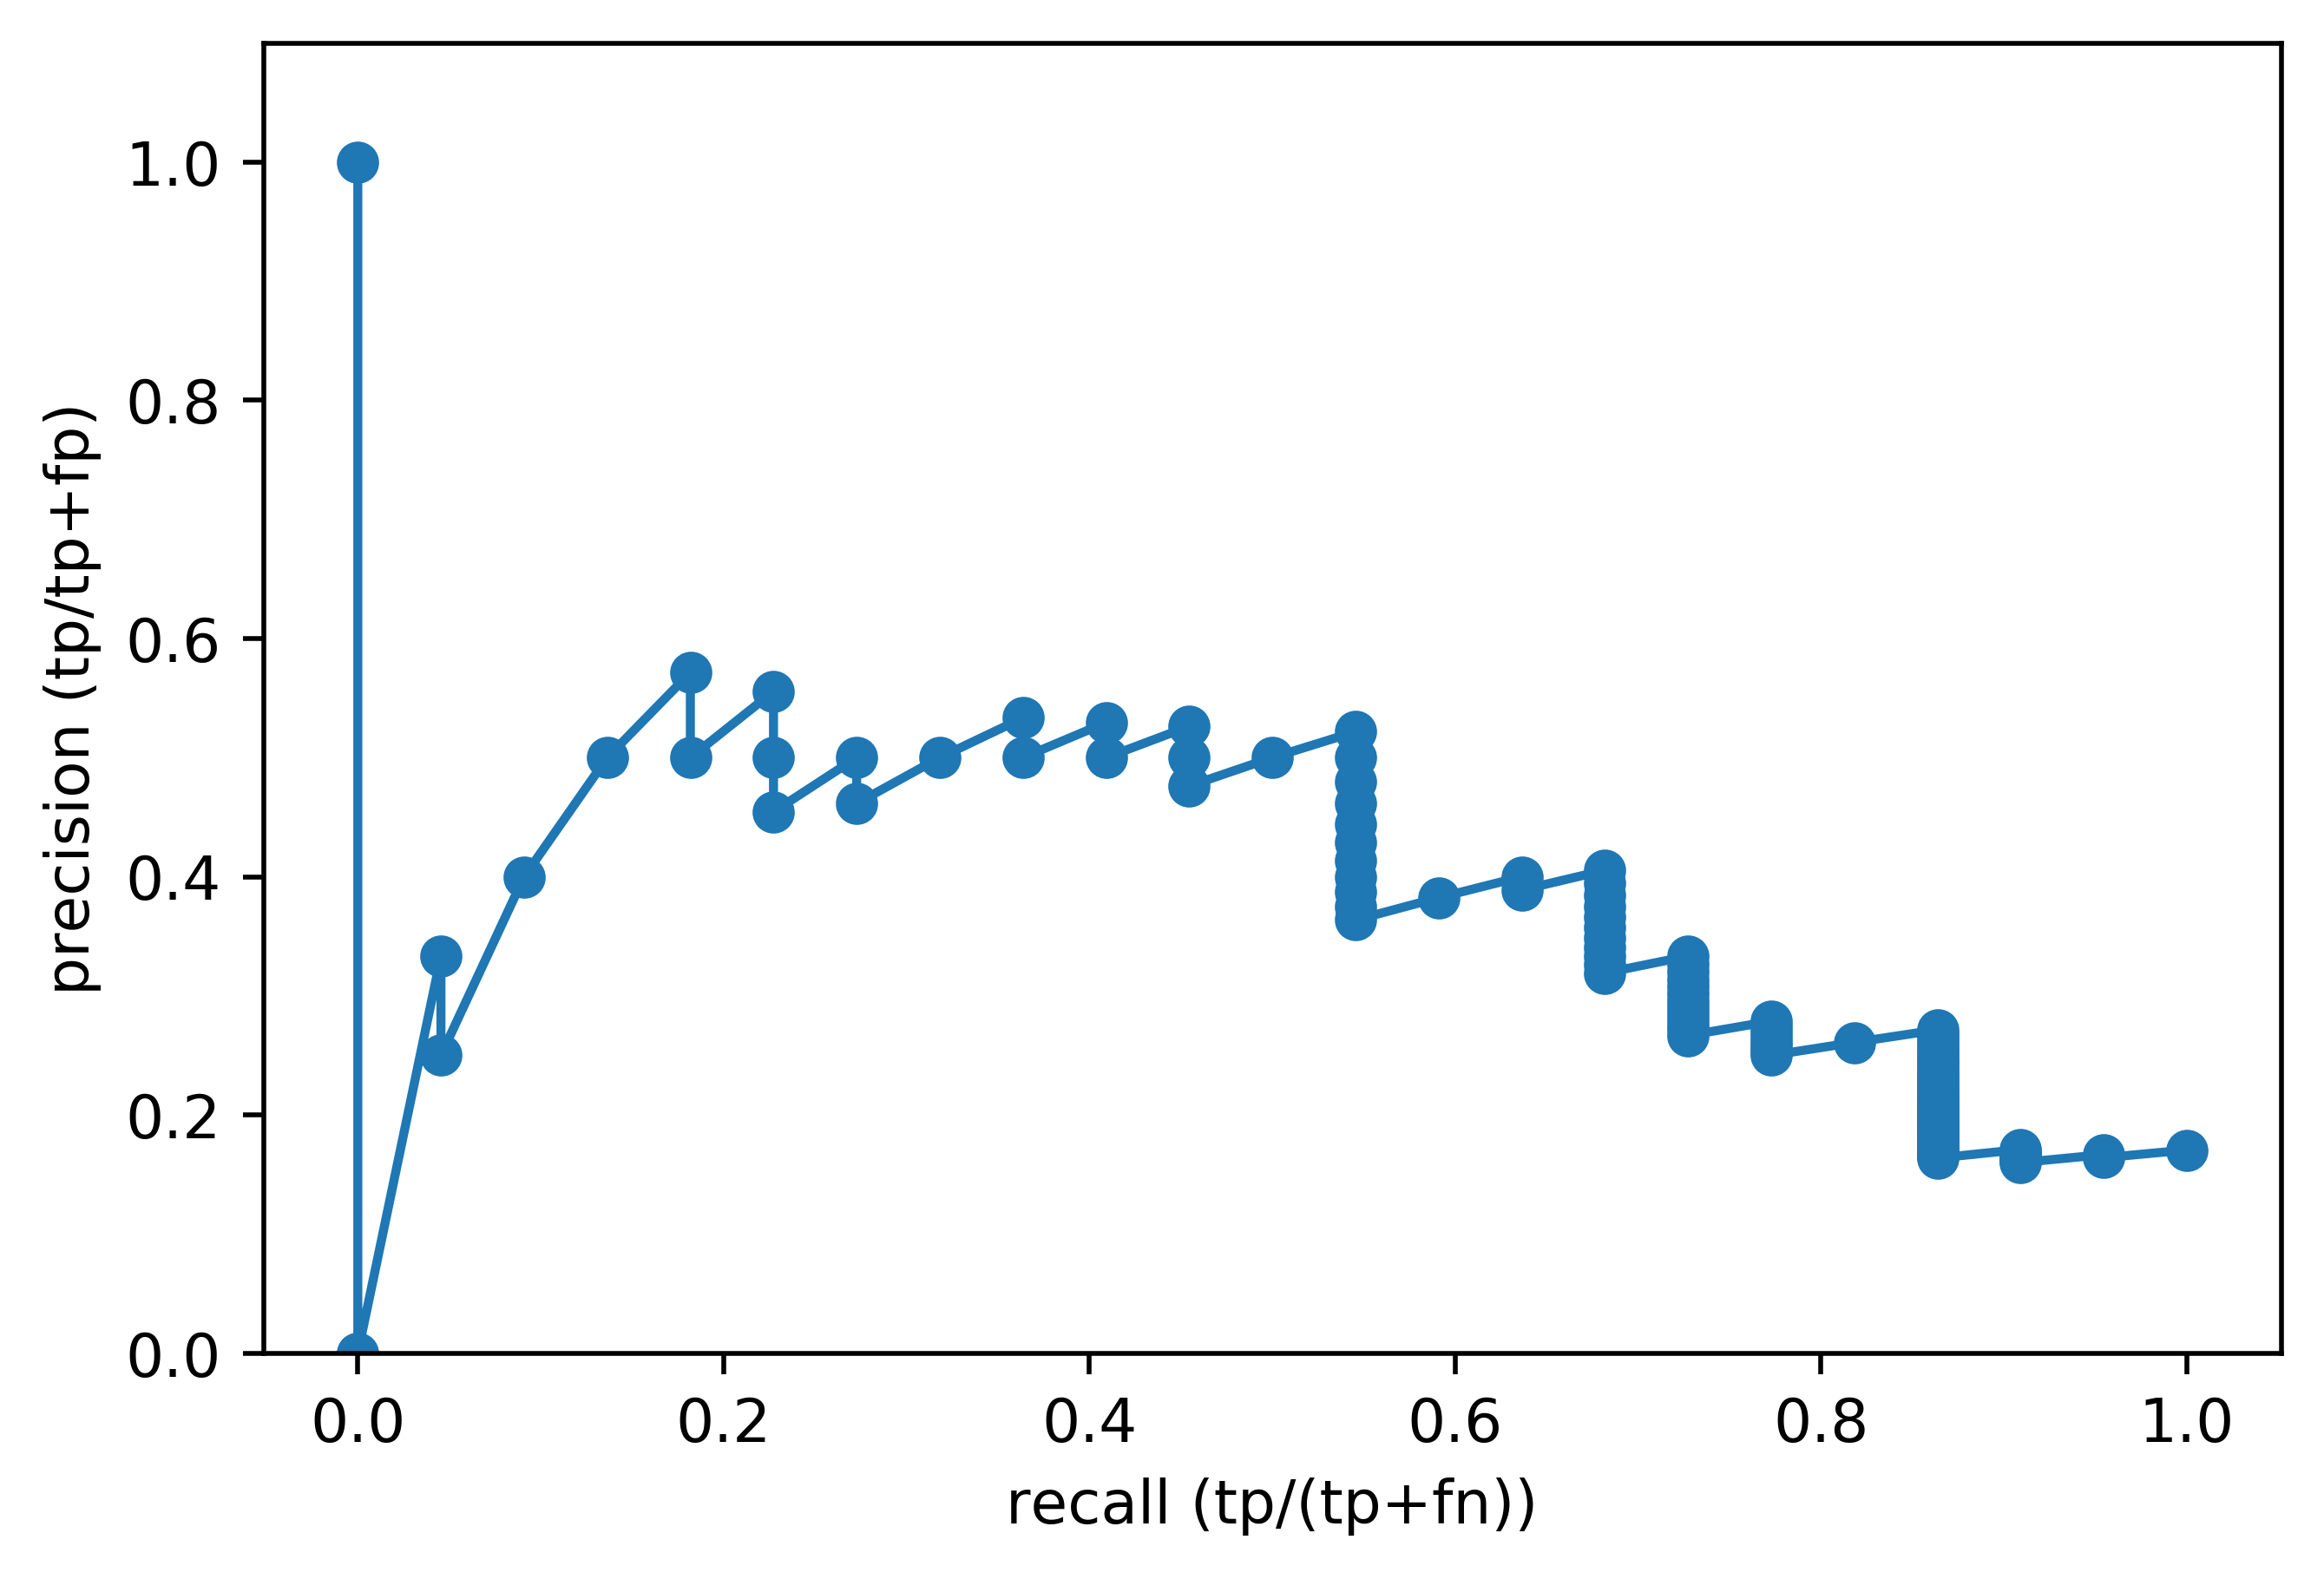

In [9]:
#fit model
feat_params = params["feat_selection"]

y_pred_cv,y_cv = helper.crossVal(X_train,y_train,X_train_blank,mol_names,trainFunc,predictFunc,params,k=20,numCores=20)

selected_feats = helper.featureSelection(X_train,y_train,X_train_blank,mol_names,feat_params,True,True)
X_train_sig = X_train[:,selected_feats]
obj = trainFunc(X_train, y_train, X_train_blank, mol_names, params)

#predict
y_pred_train = predictFunc(obj,X_train)

#assess training error
err_train = helper.score(y_pred_train,y_train)
print("training score: ",err_train)
#print(sklearn.metrics.confusion_matrix(y_train,y_pred))

plt.figure()

precision,recall,thresolds = sklearn.metrics.precision_recall_curve(y_cv,y_pred_cv)
plt.plot(recall,precision)
plt.scatter(recall,precision)
plt.xlabel("recall (tp/(tp+fn))")
plt.ylabel("precision (tp/tp+fp)")
plt.ylim((0,1.1))
for p,r,t in zip(precision,recall,thresolds):
    print(p,r,t)

#assess testing error
y_test_pred = predictFunc(obj,X_test)

err_test = helper.score(y_test_pred,y_test)
print("testing score: ",err_test)
#print(sklearn.metrics.confusion_matrix(y_test,y_test_pred))

y_neg_pred = [y_test_pred[i] for i in range(len(y_test_pred)) if y_test[i] < .5]
y_pos_pred = [y_test_pred[i] for i in range(len(y_test_pred)) if y_test[i] > .5]

y_val_pred = predictFunc(obj,X_val)

    





6


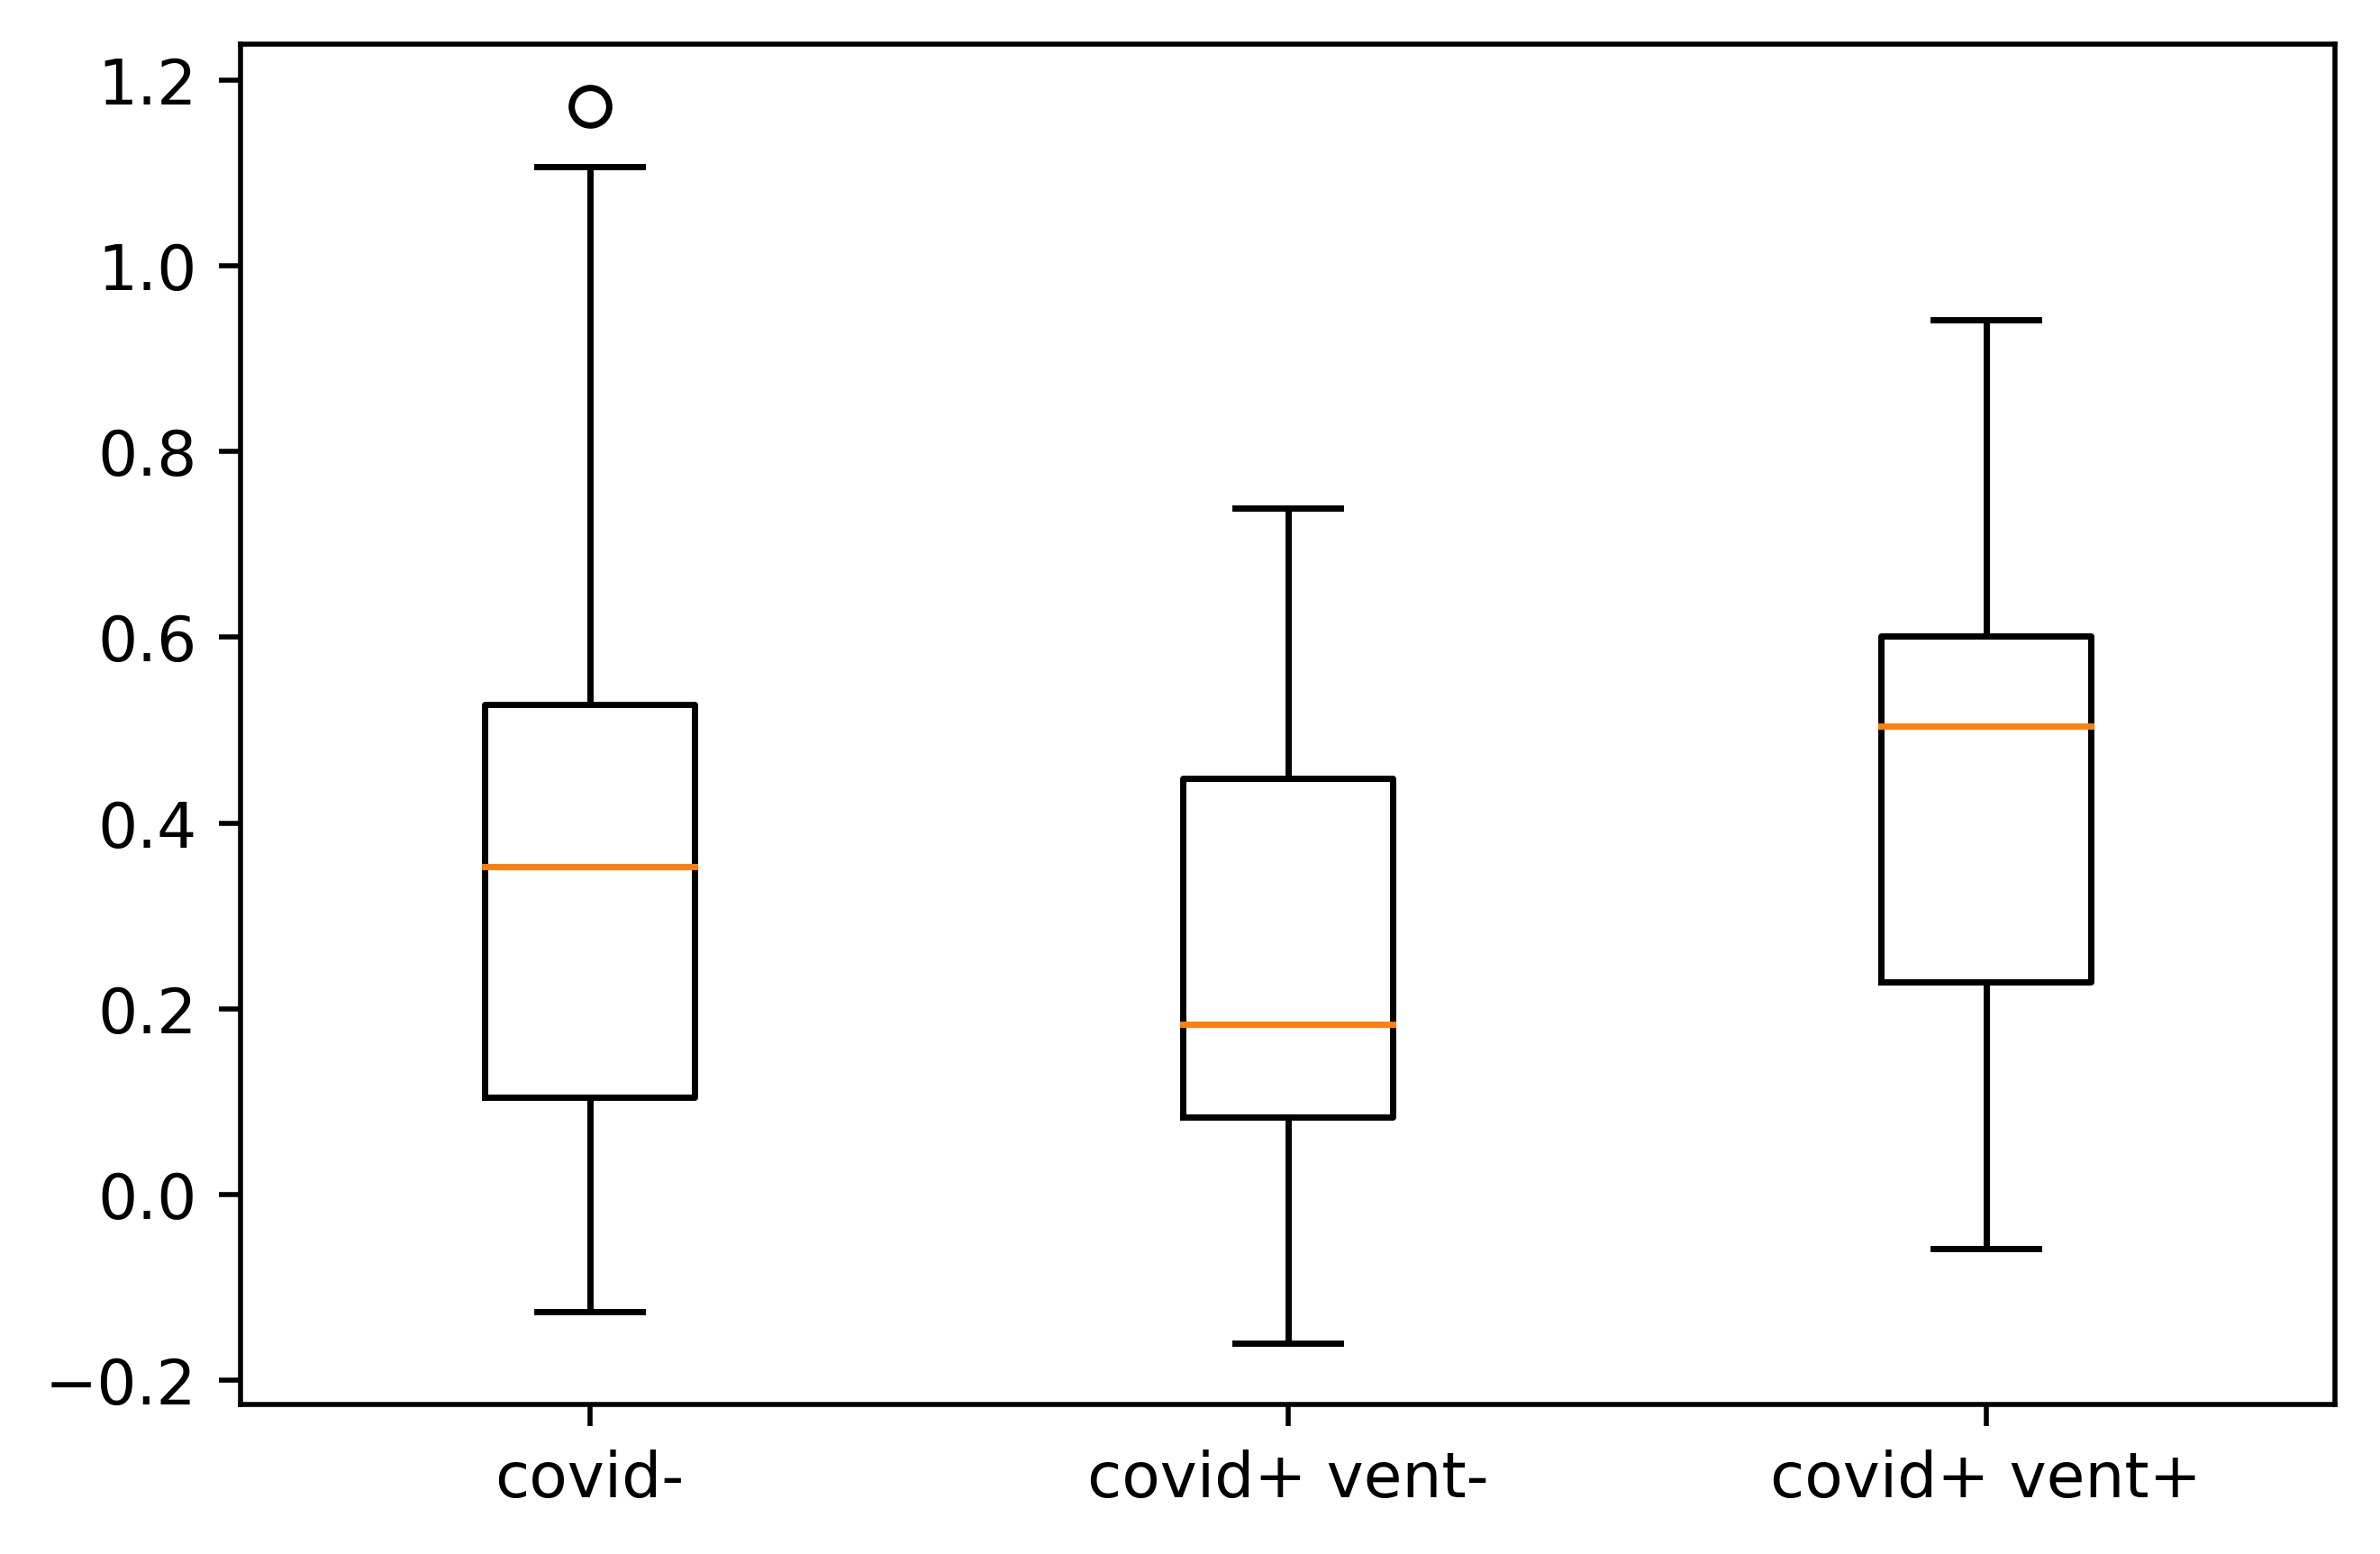

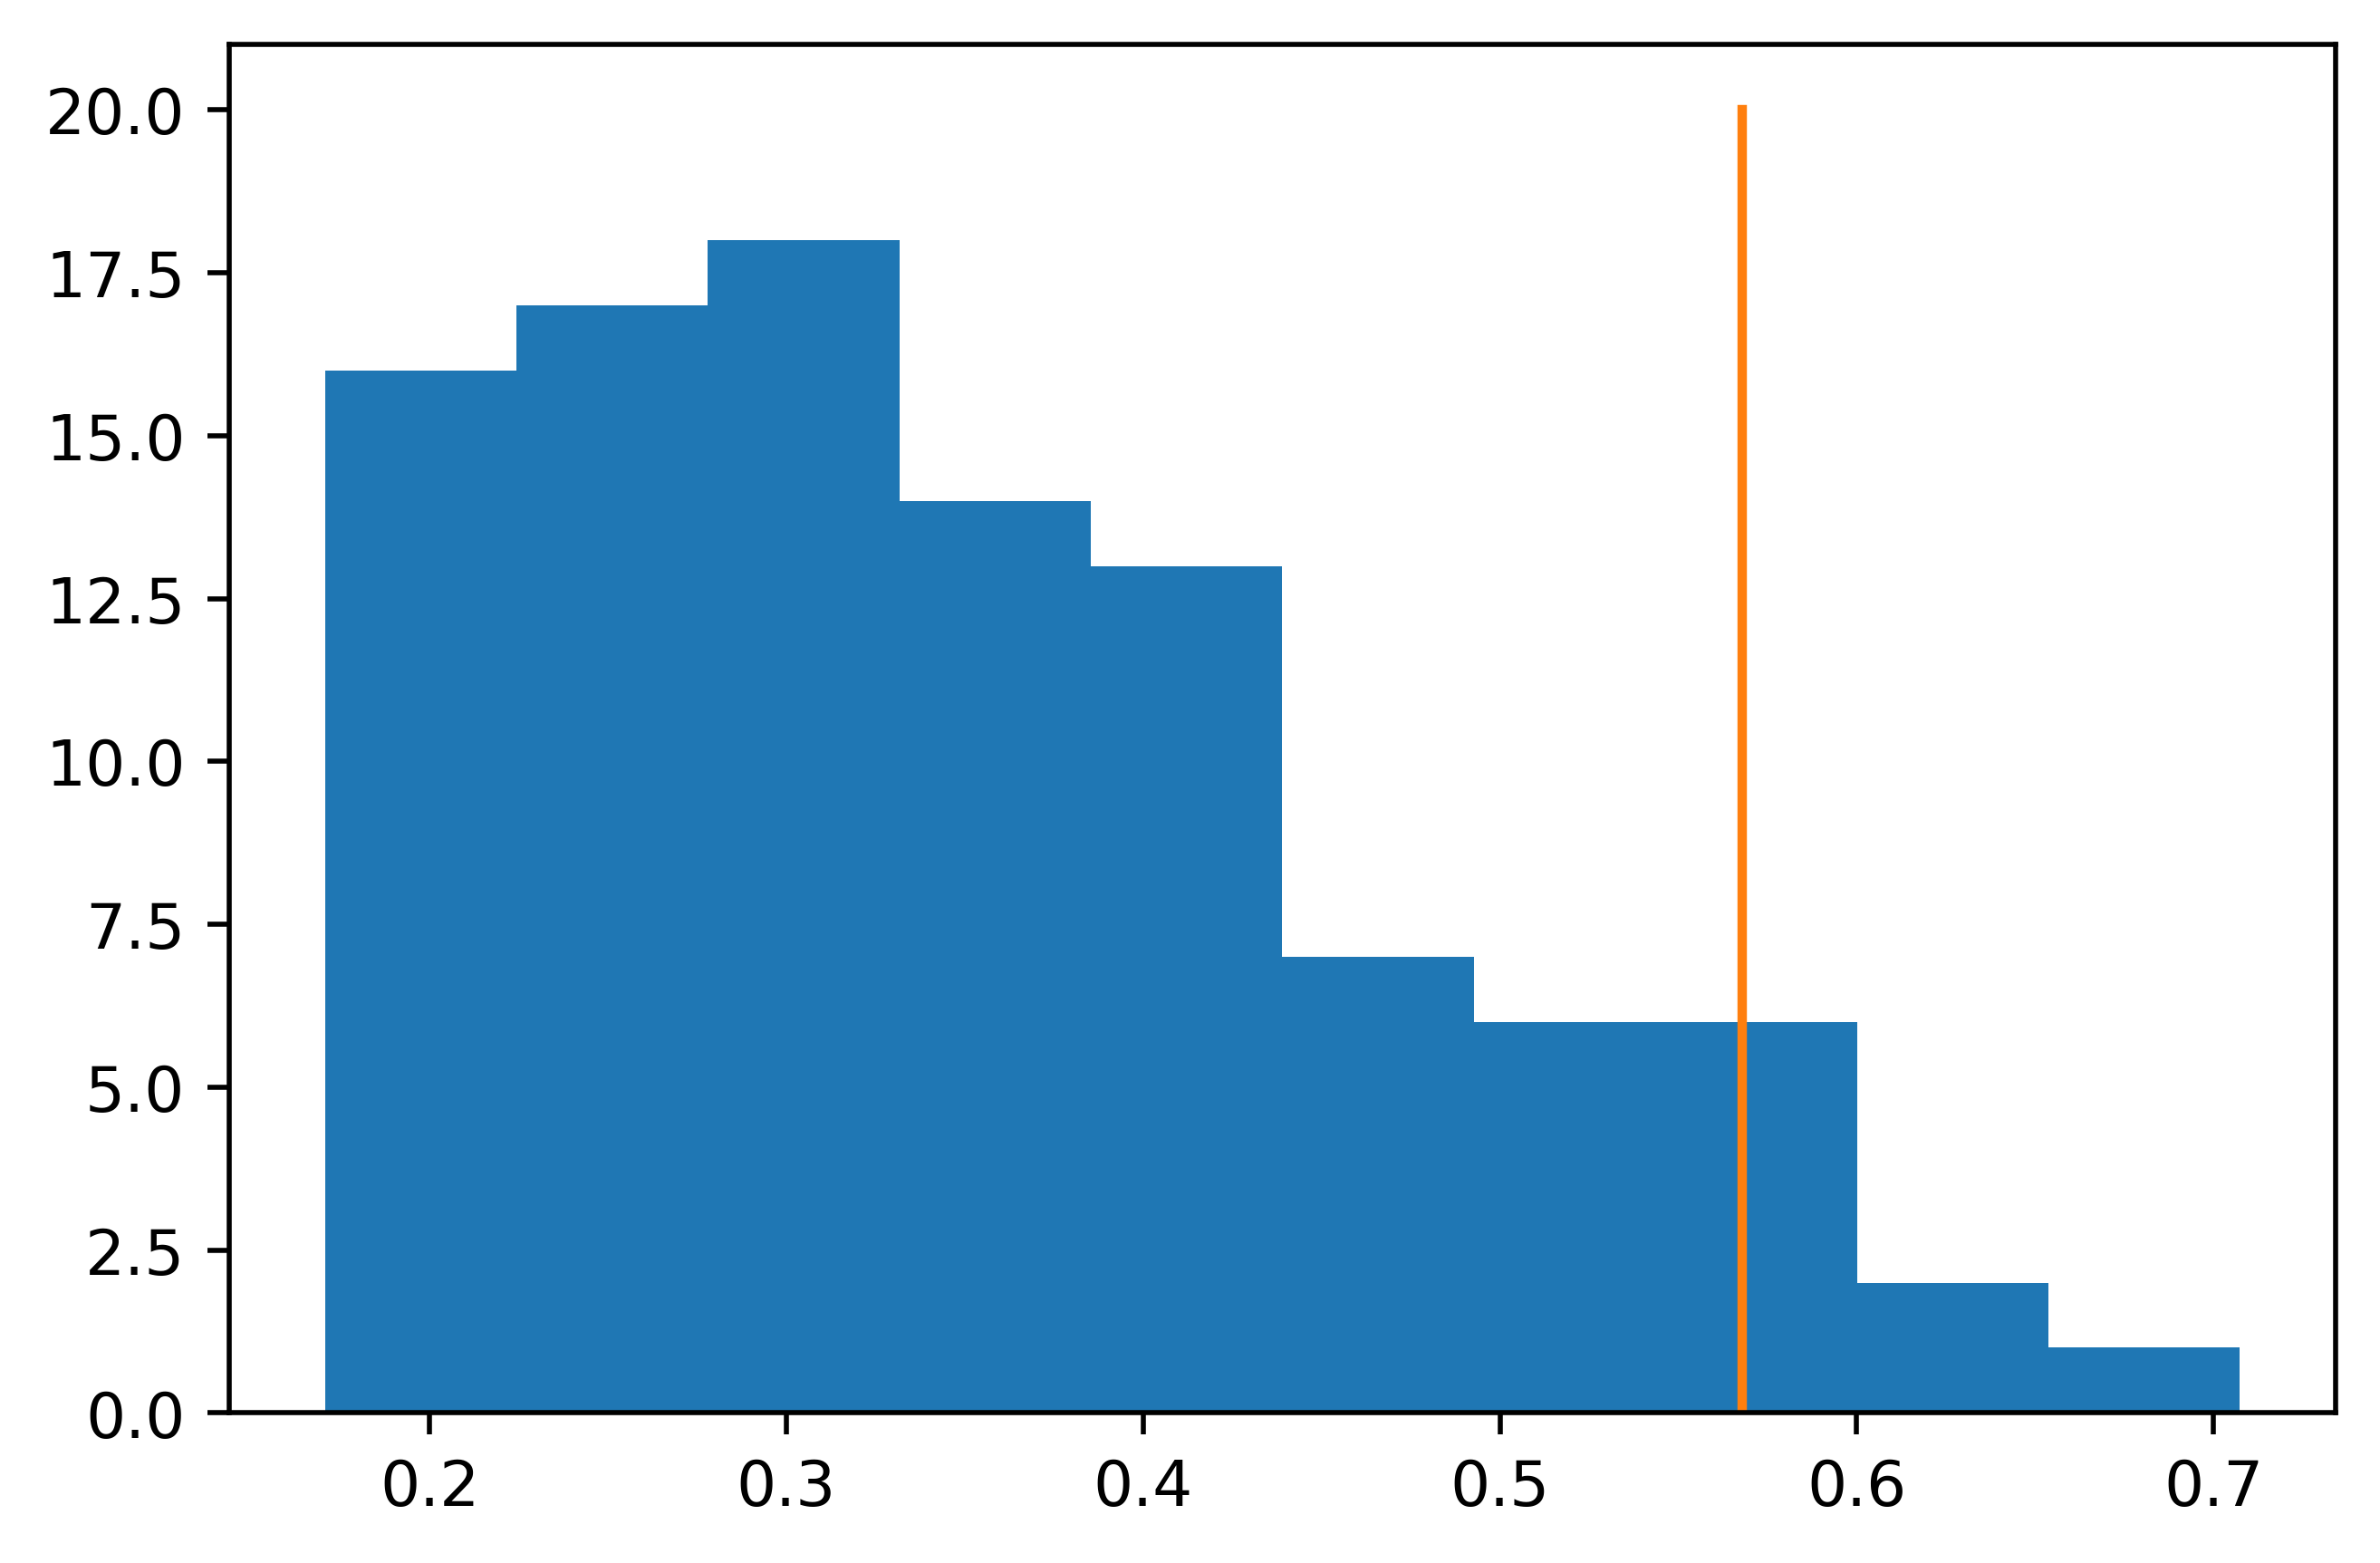

In [11]:
thresh = 0.56
plt.figure()
plt.boxplot([y_val_pred,y_neg_pred,y_pos_pred],labels=["covid-","covid+ vent-","covid+ vent+"])
#plt.plot(range(1,4),[thresh for _ in range(1,4)])

#y_val_pred_bin = binarize(y_val_pred,thresh)
#y_test_pred_bin = binarize(y_test_pred,thresh)

# print(sklearn.metrics.confusion_matrix(y_val,y_val_pred_bin))
# print(sklearn.metrics.confusion_matrix(y_test,y_test_pred_bin))



#permutation test
numPerm = 100
res = []
for _ in range(numPerm):
    order = list(range(len(y_train)))
    rd.shuffle(order)
    y_shuff = np.array([y_train[x] for x in order])
    obj = trainFunc(X_train, y_shuff, X_train_blank, mol_names, params)
    y_pred = predictFunc(obj,X_test)
    err_shuff = helper.score(y_pred,y_test)
    res.append(err_shuff)
    
print(len([x for x in res if x > err_test]))
    
#plot histogram
plt.figure()
plt.hist(res)
plt.plot([err_test,err_test],[0,.2*numPerm])

(0, 1.1)

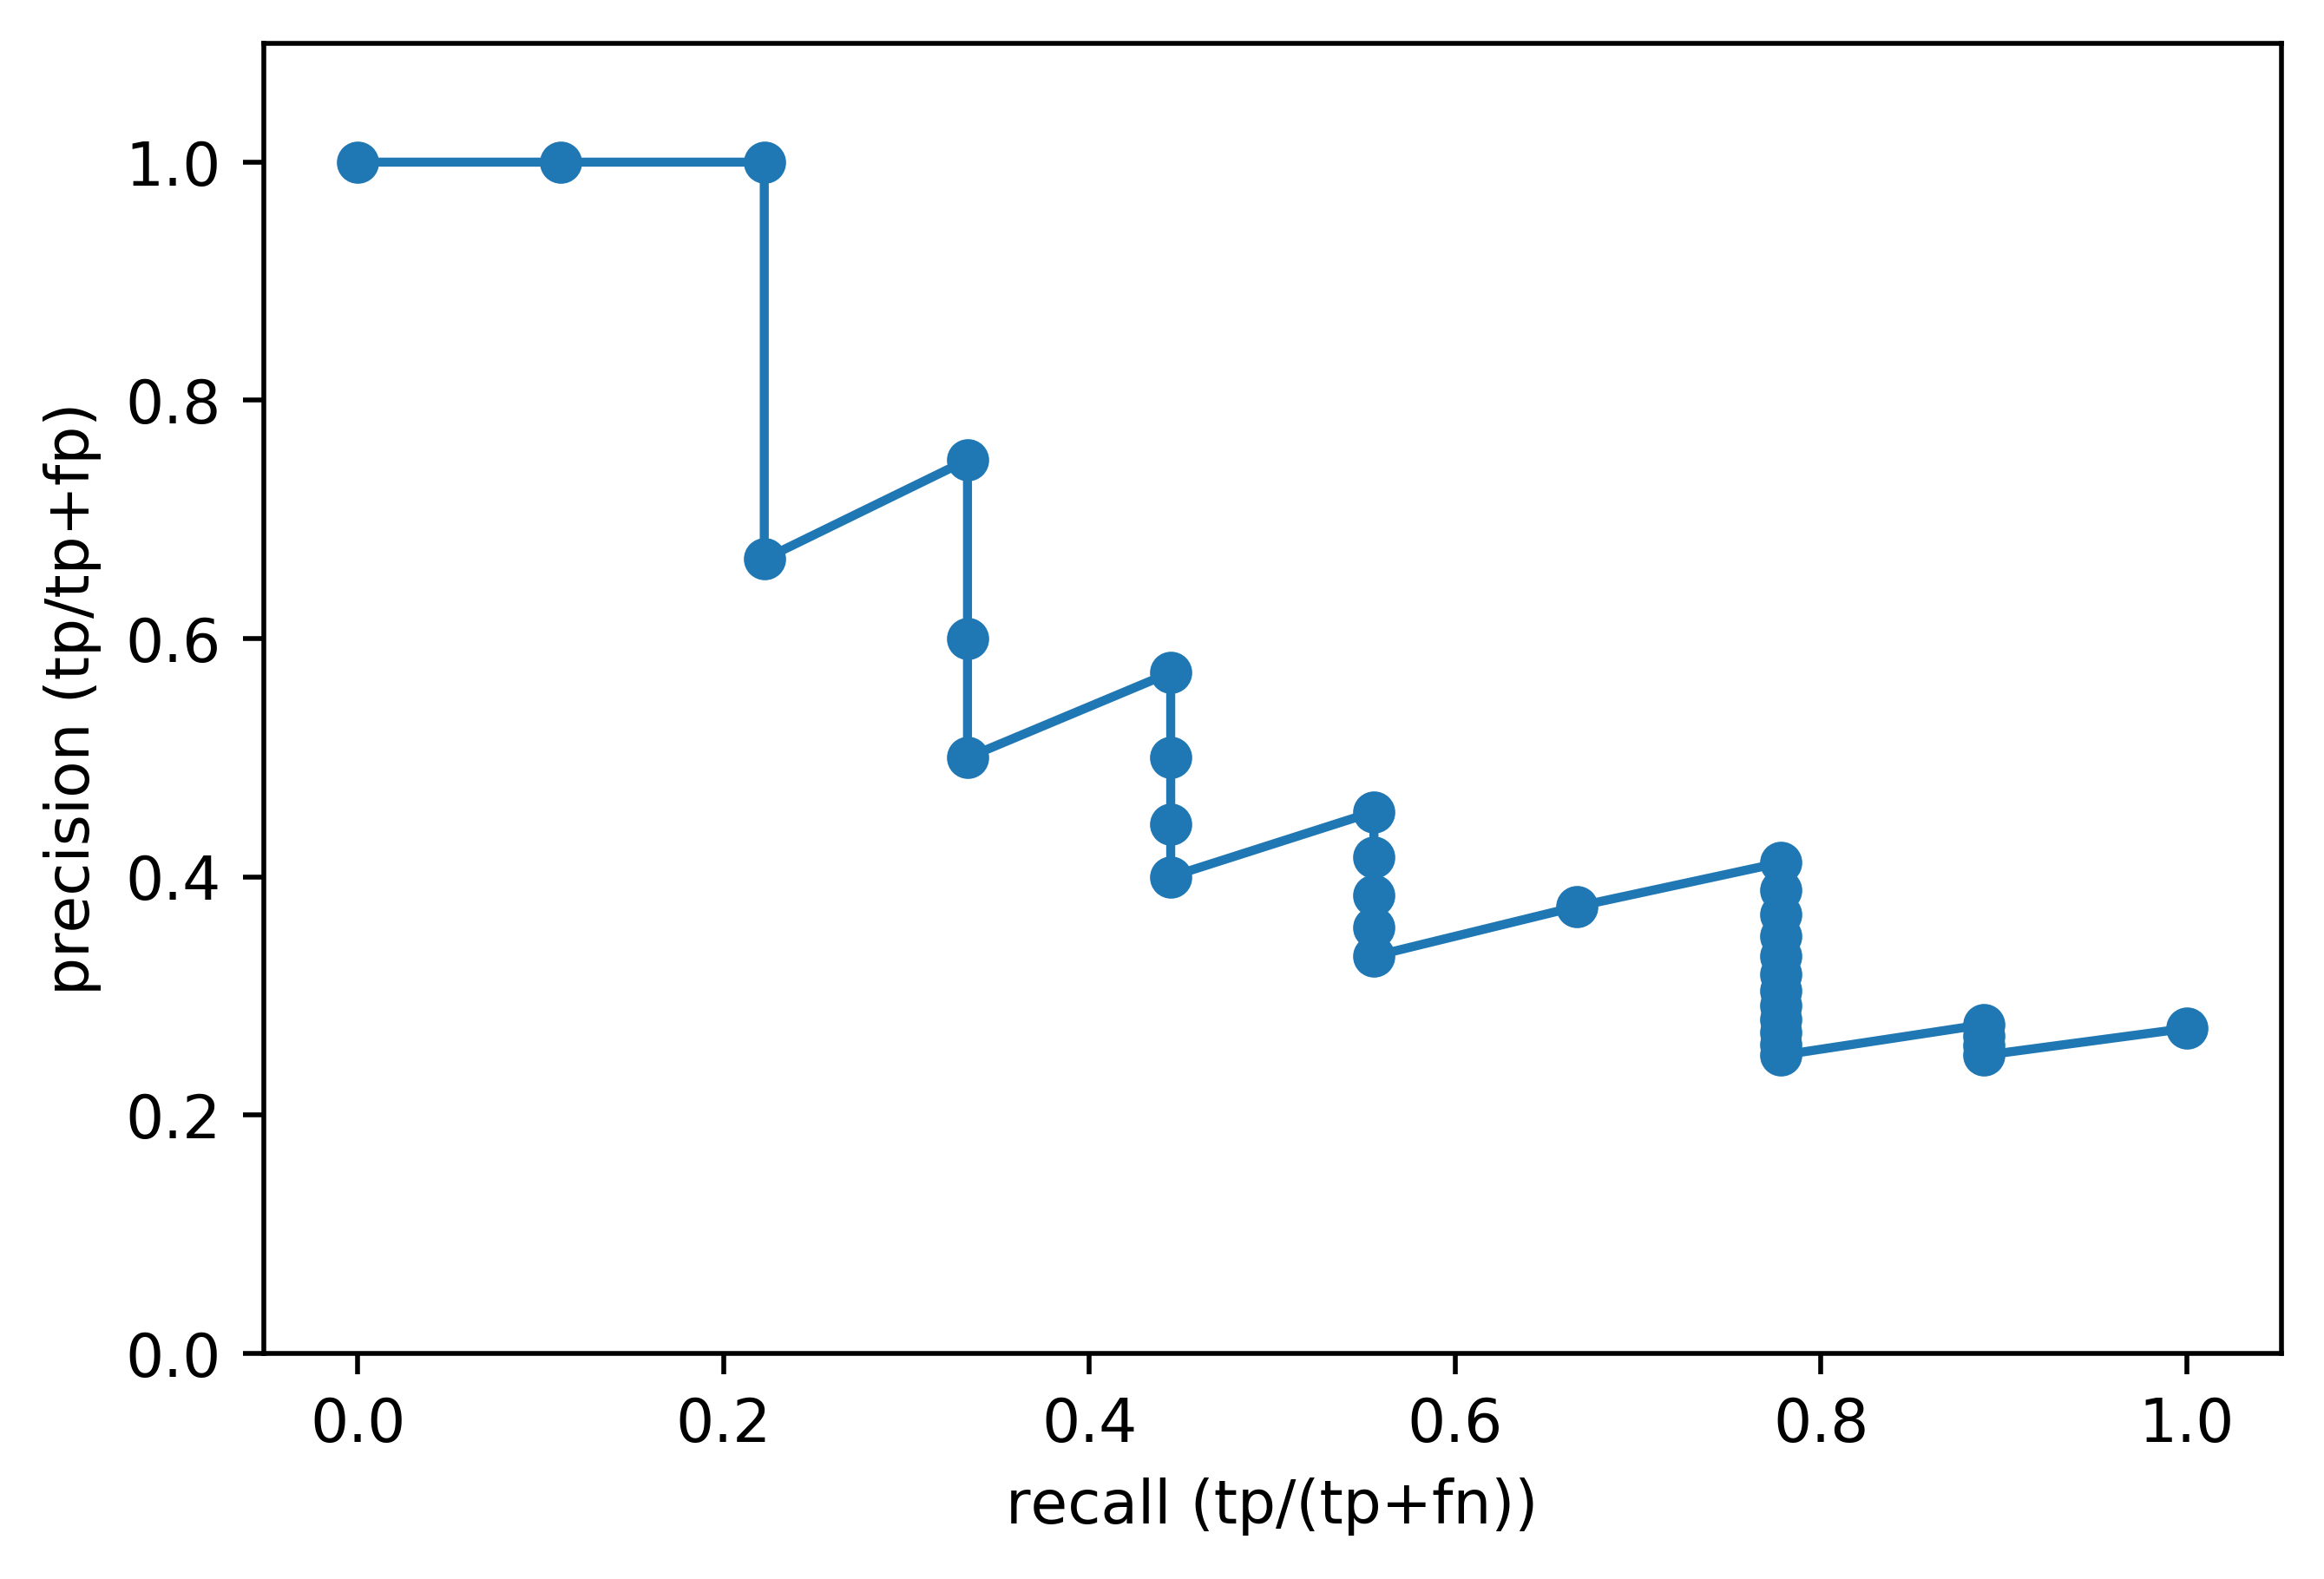

In [12]:
precision,recall,thresolds = sklearn.metrics.precision_recall_curve(y_test,y_test_pred)
plt.plot(recall,precision)
plt.scatter(recall,precision)
plt.xlabel("recall (tp/(tp+fn))")
plt.ylabel("precision (tp/tp+fp)")
plt.ylim((0,1.1))


2337
519
training score:  0.9937283797845711
2337
4


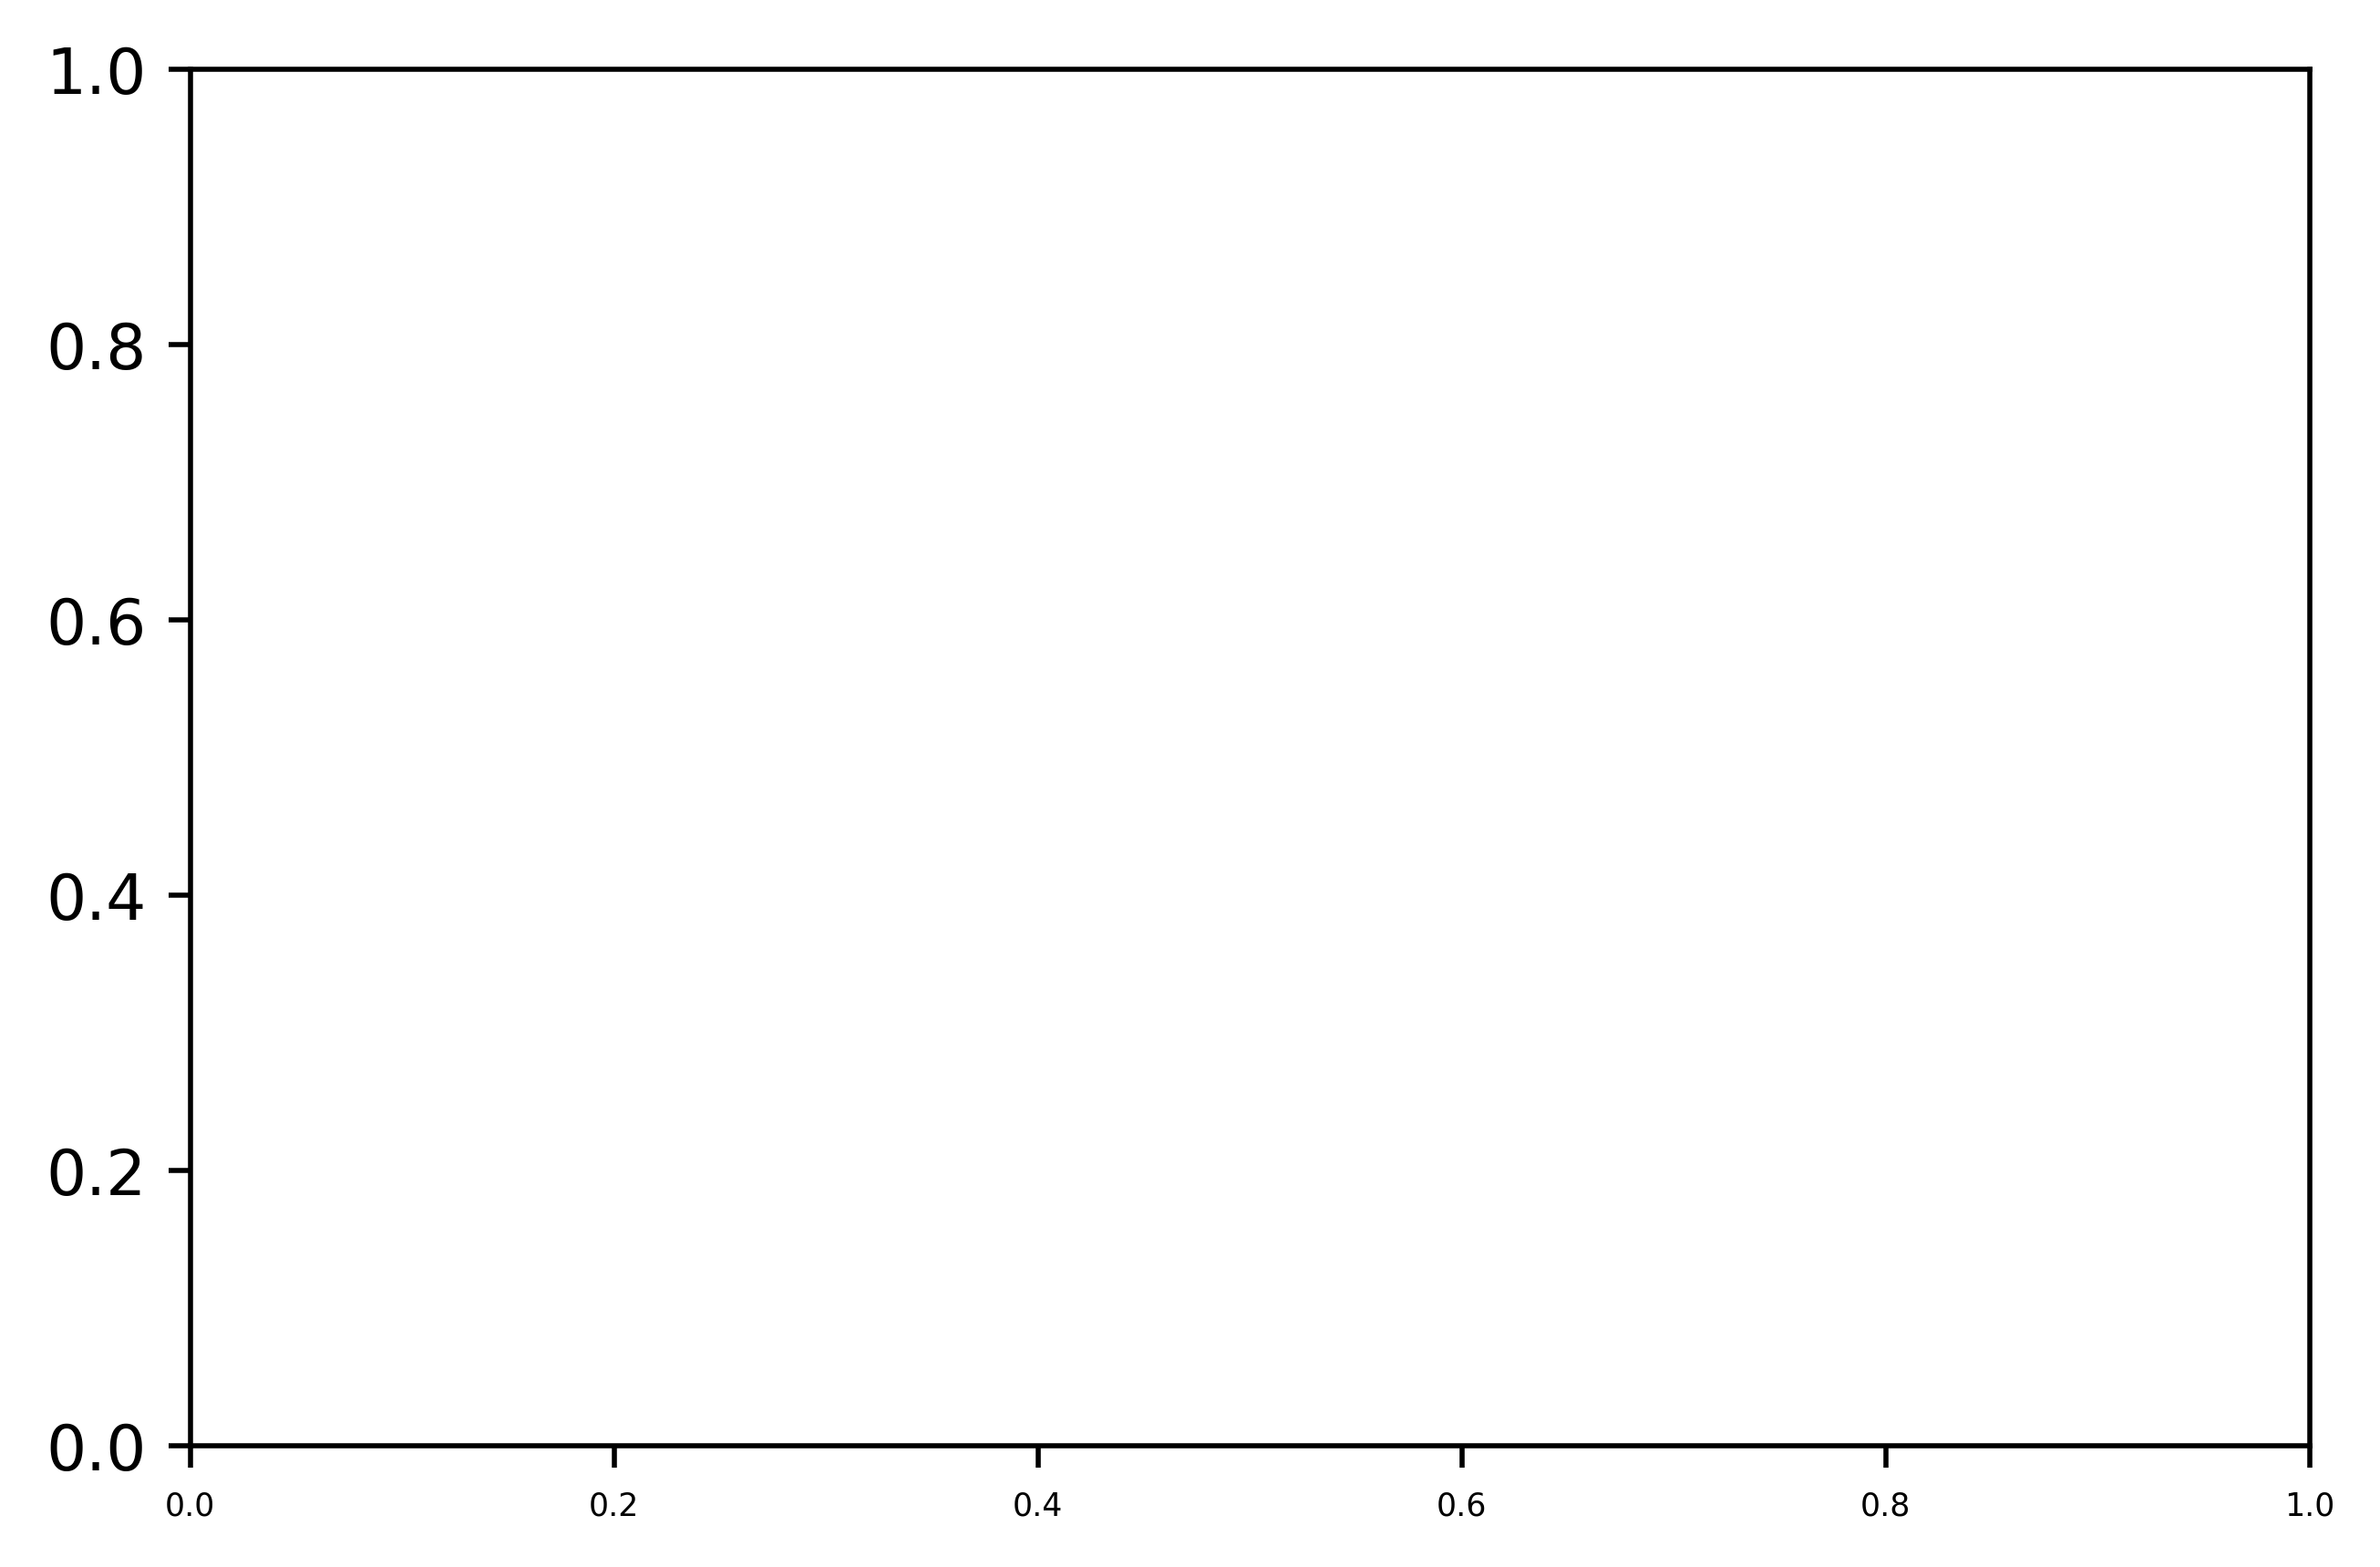

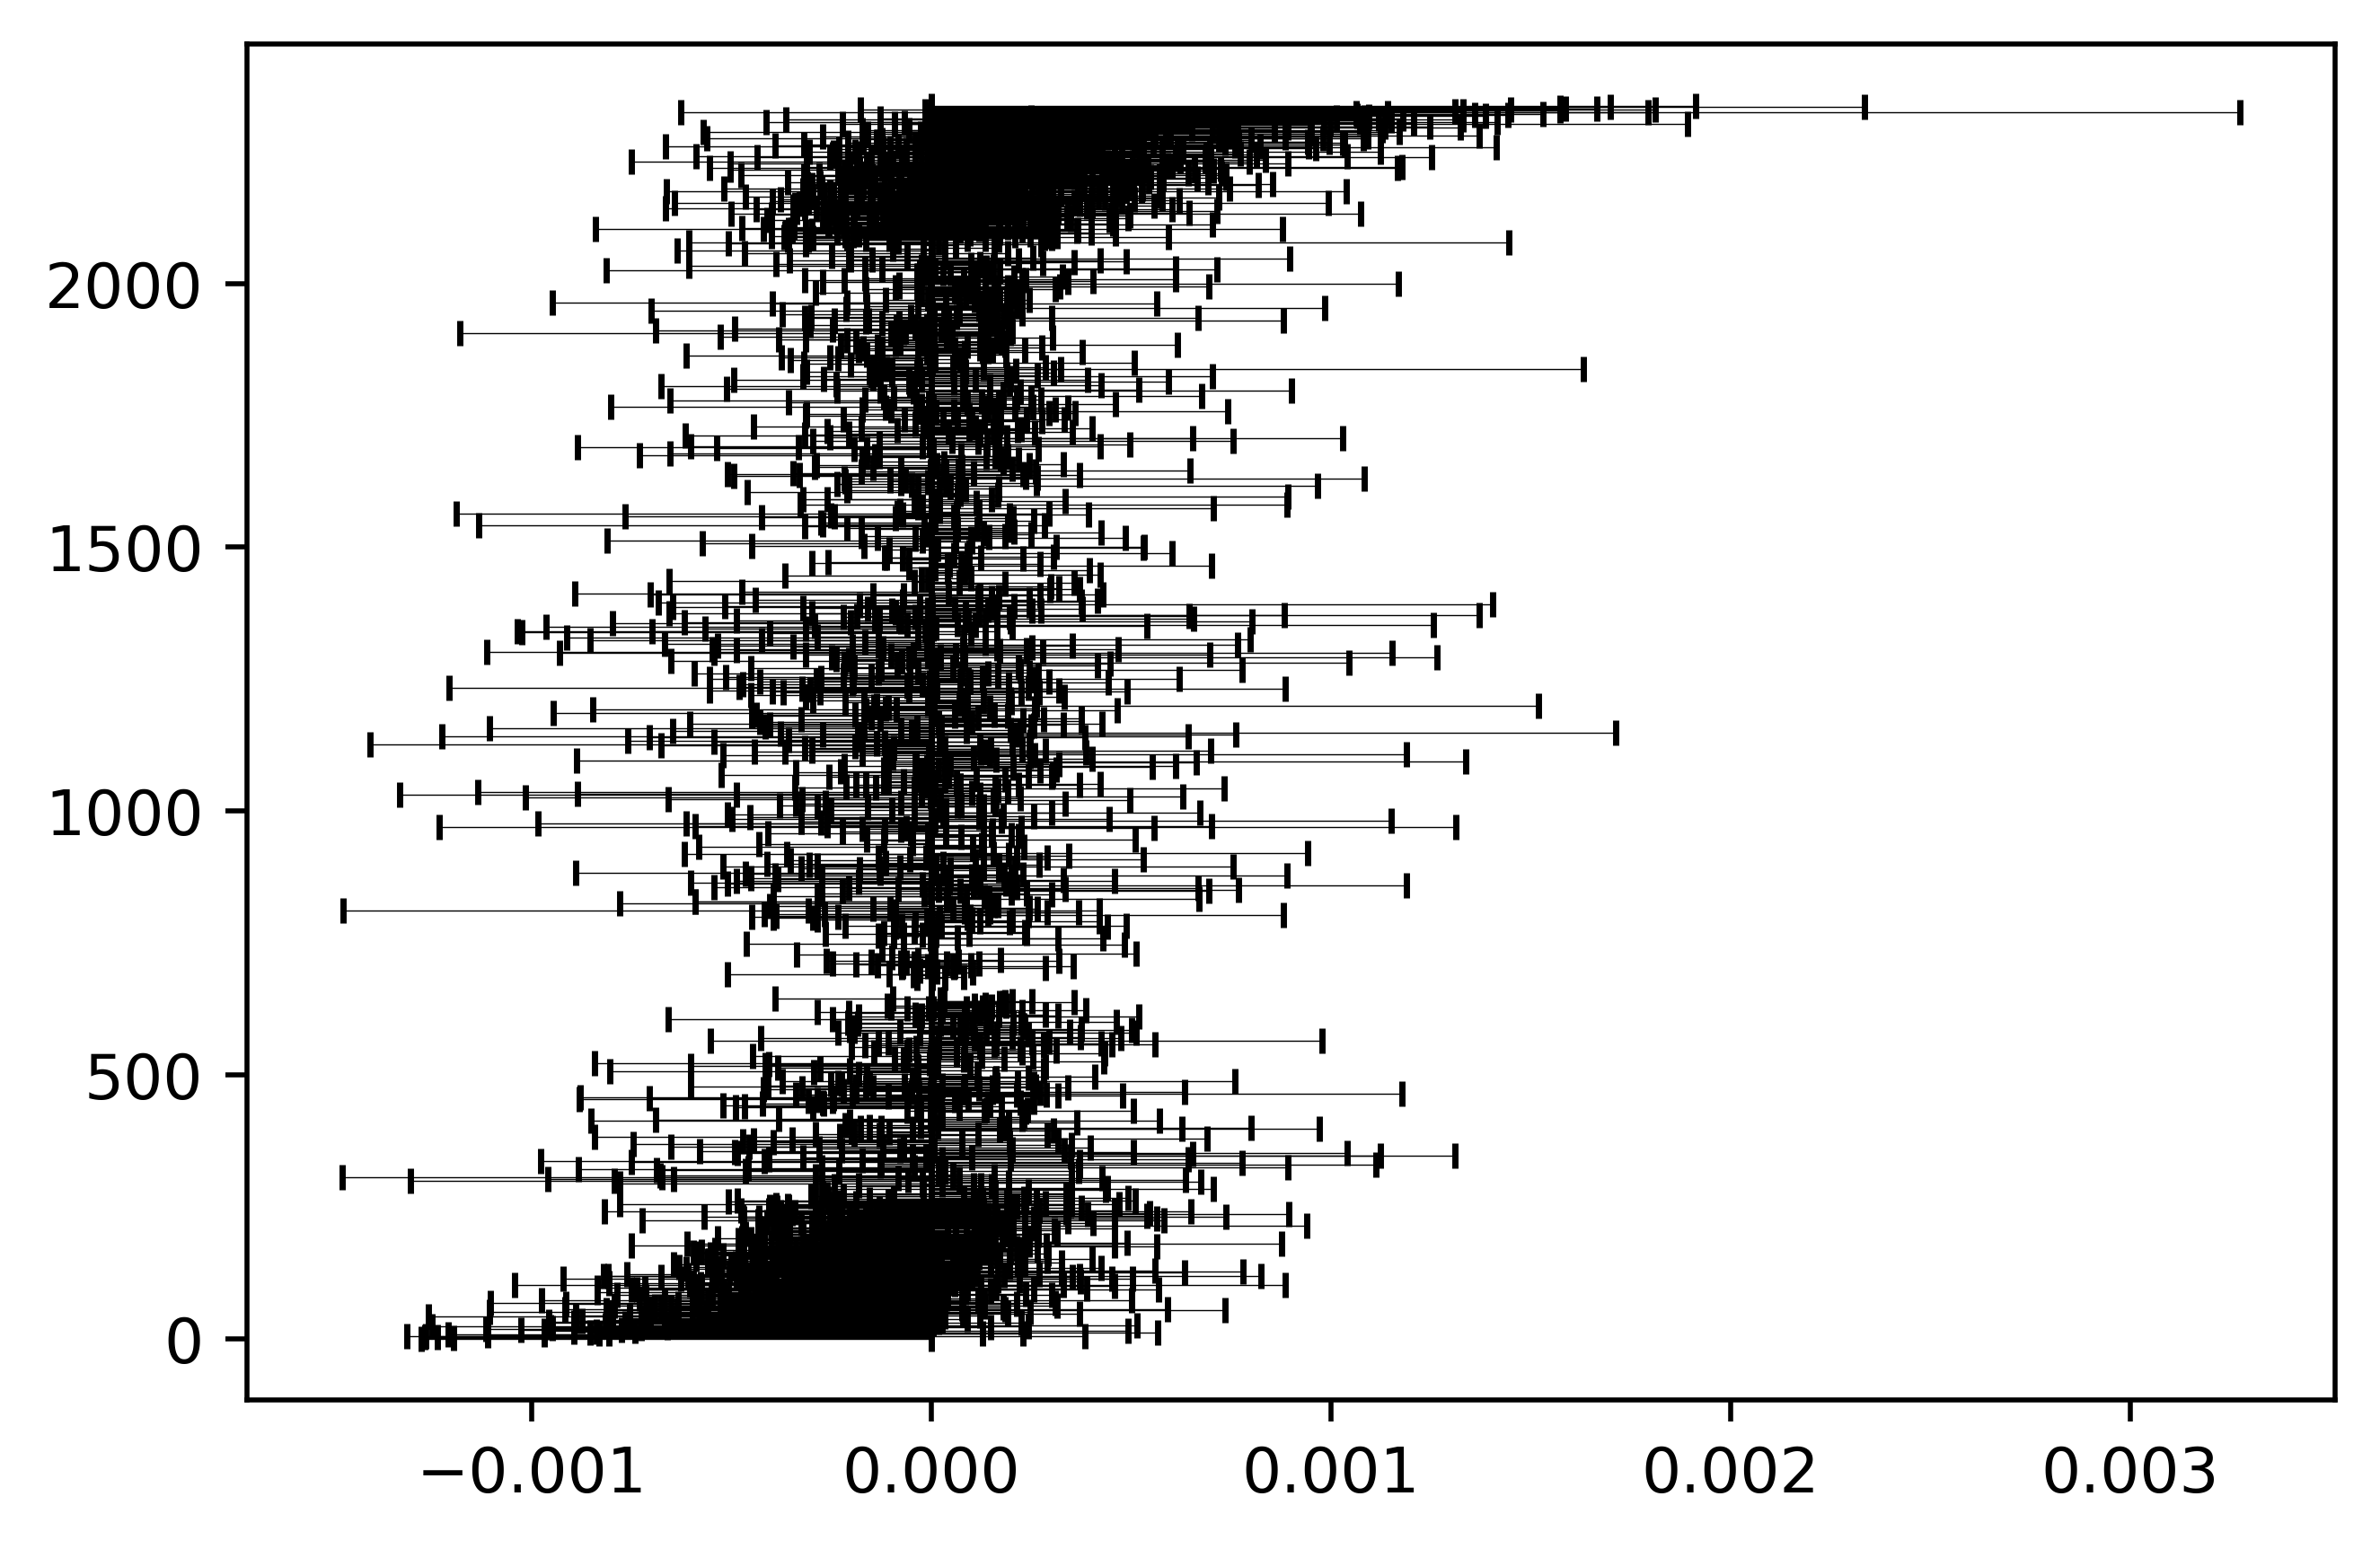

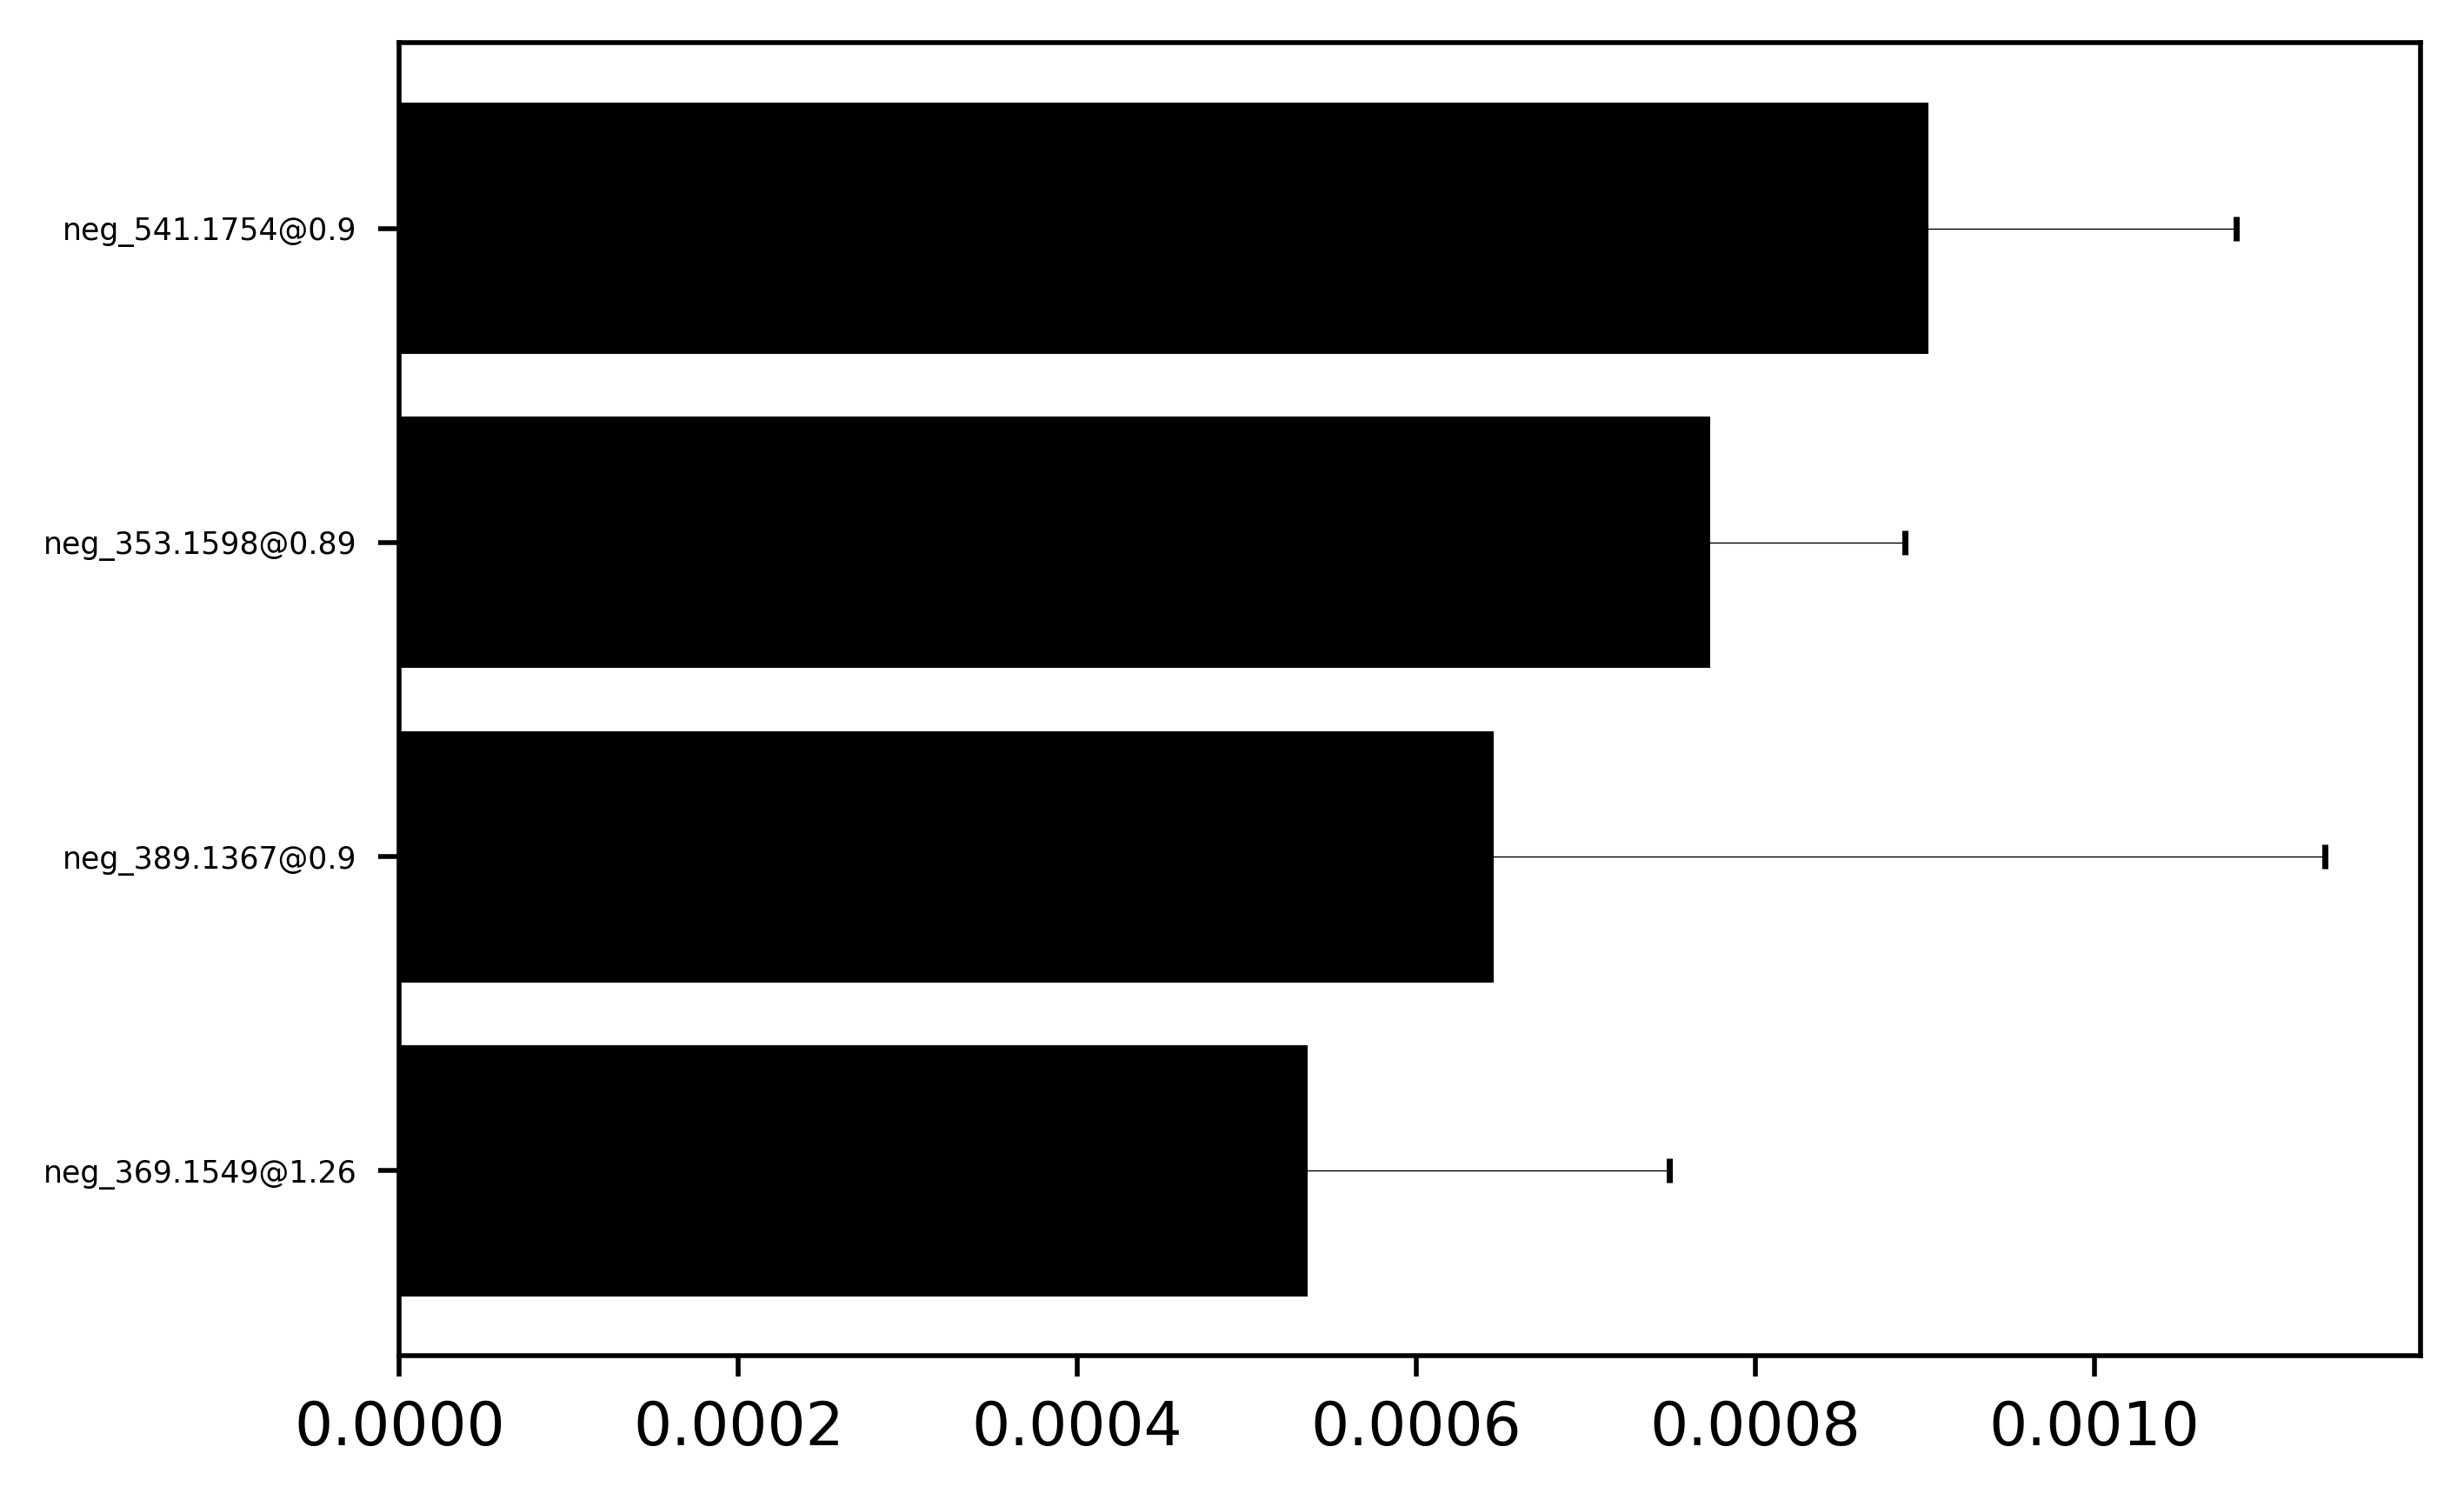

In [14]:

#train on entire dataset
negSamples = [x for x in range(len(samp_vent)) if samp_vent[x] == 0]
X = d_whole_norm[:len(samp_int)]
X_blank = d_whole_norm[len(samp_int):len(samp_int)+len(blank_int)]
y = np.array([1 for _ in X])
for x in negSamples:
    y[x] = 0
plt.figure()
feat_params = params["feat_selection"]
selected_feats = helper.featureSelection(X,y,X_blank,mol_names,feat_params,True,True)


#bootstrap samples
poss = list(range(len(X)))
numBoots = 100
coefs = np.zeros((numBoots,len(mol_names)))
for x in range(numBoots):
    samp = rd.choices(poss,k=len(poss))
    X_temp = X[samp]
    y_temp = y[samp]
    obj = trainFunc(X_temp,y_temp,X_blank,mol_names,params)
    coefs[x][obj._selectedvars] = np.array(flatten(obj.coef_.tolist()))
    coefs[x] = np.array([coefs[x][i]/np.median(X_temp[:,i]) for i in range(len(mol_names))])
coefs = np.array(coefs).transpose()
print(len(coefs))

coefs_ci = np.array([(np.percentile(x,2.5),np.percentile(x,97.5)) for x in coefs])

print(len(selected_feats))
obj = trainFunc(X, y, X_blank, mol_names, params)
y_pred = predictFunc(obj,X)
err_train = helper.score(y_pred,y)
print("training score: ",err_train)
#print(sklearn.metrics.confusion_matrix(y,y_pred))
plt.xticks(fontsize=5)
plt.figure()


var_imp = np.zeros((len(mol_names)))
var_imp[obj._selectedvars] = np.array(flatten(obj.coef_.tolist()))
var_imp = np.array([var_imp[x]/np.median(X[:,x]) for x in range(len(var_imp))])

coefs_ci_normed = np.array([np.abs(r - vi) for r,vi in zip(coefs_ci,var_imp)])
print(len(var_imp))
order = list(range(len(var_imp)))
order.sort(key=lambda x:var_imp[x])
var_imp = var_imp[order]
coefs = coefs[order]
coefs_ci = coefs_ci[order]
coefs_ci_normed = coefs_ci_normed[order]

plt.barh(range(len(var_imp)),width = var_imp,xerr=[coefs_ci_normed[:,0],coefs_ci_normed[:,1]],ecolor="black",capsize=2,error_kw={"elinewidth":0.2,"barsabove":False},color="black")

plt.figure()

#filter out feats passing zero

goodMets = []
for x in range(len(coefs)):
    if coefs_ci[x][0] * coefs_ci[x][1] > 0:
        goodMets.append(x)
        
mol_names_sorted = mol_names[order]

plt.barh(range(len(goodMets)),width = var_imp[goodMets],xerr=[coefs_ci_normed[goodMets,0],coefs_ci_normed[goodMets,1]],ecolor="black",capsize=2,error_kw={"elinewidth":0.2,"barsabove":False},color="black")

plt.yticks(range(len(goodMets)),mol_names_sorted[goodMets],fontsize=5)
print(len(goodMets))
    

2337 compounds sig. higher in samples than blank
210 compounds sig. diff between vent+ and vent-
210 compounds sig. diff between vent+ and vent- and sig. higher than blank


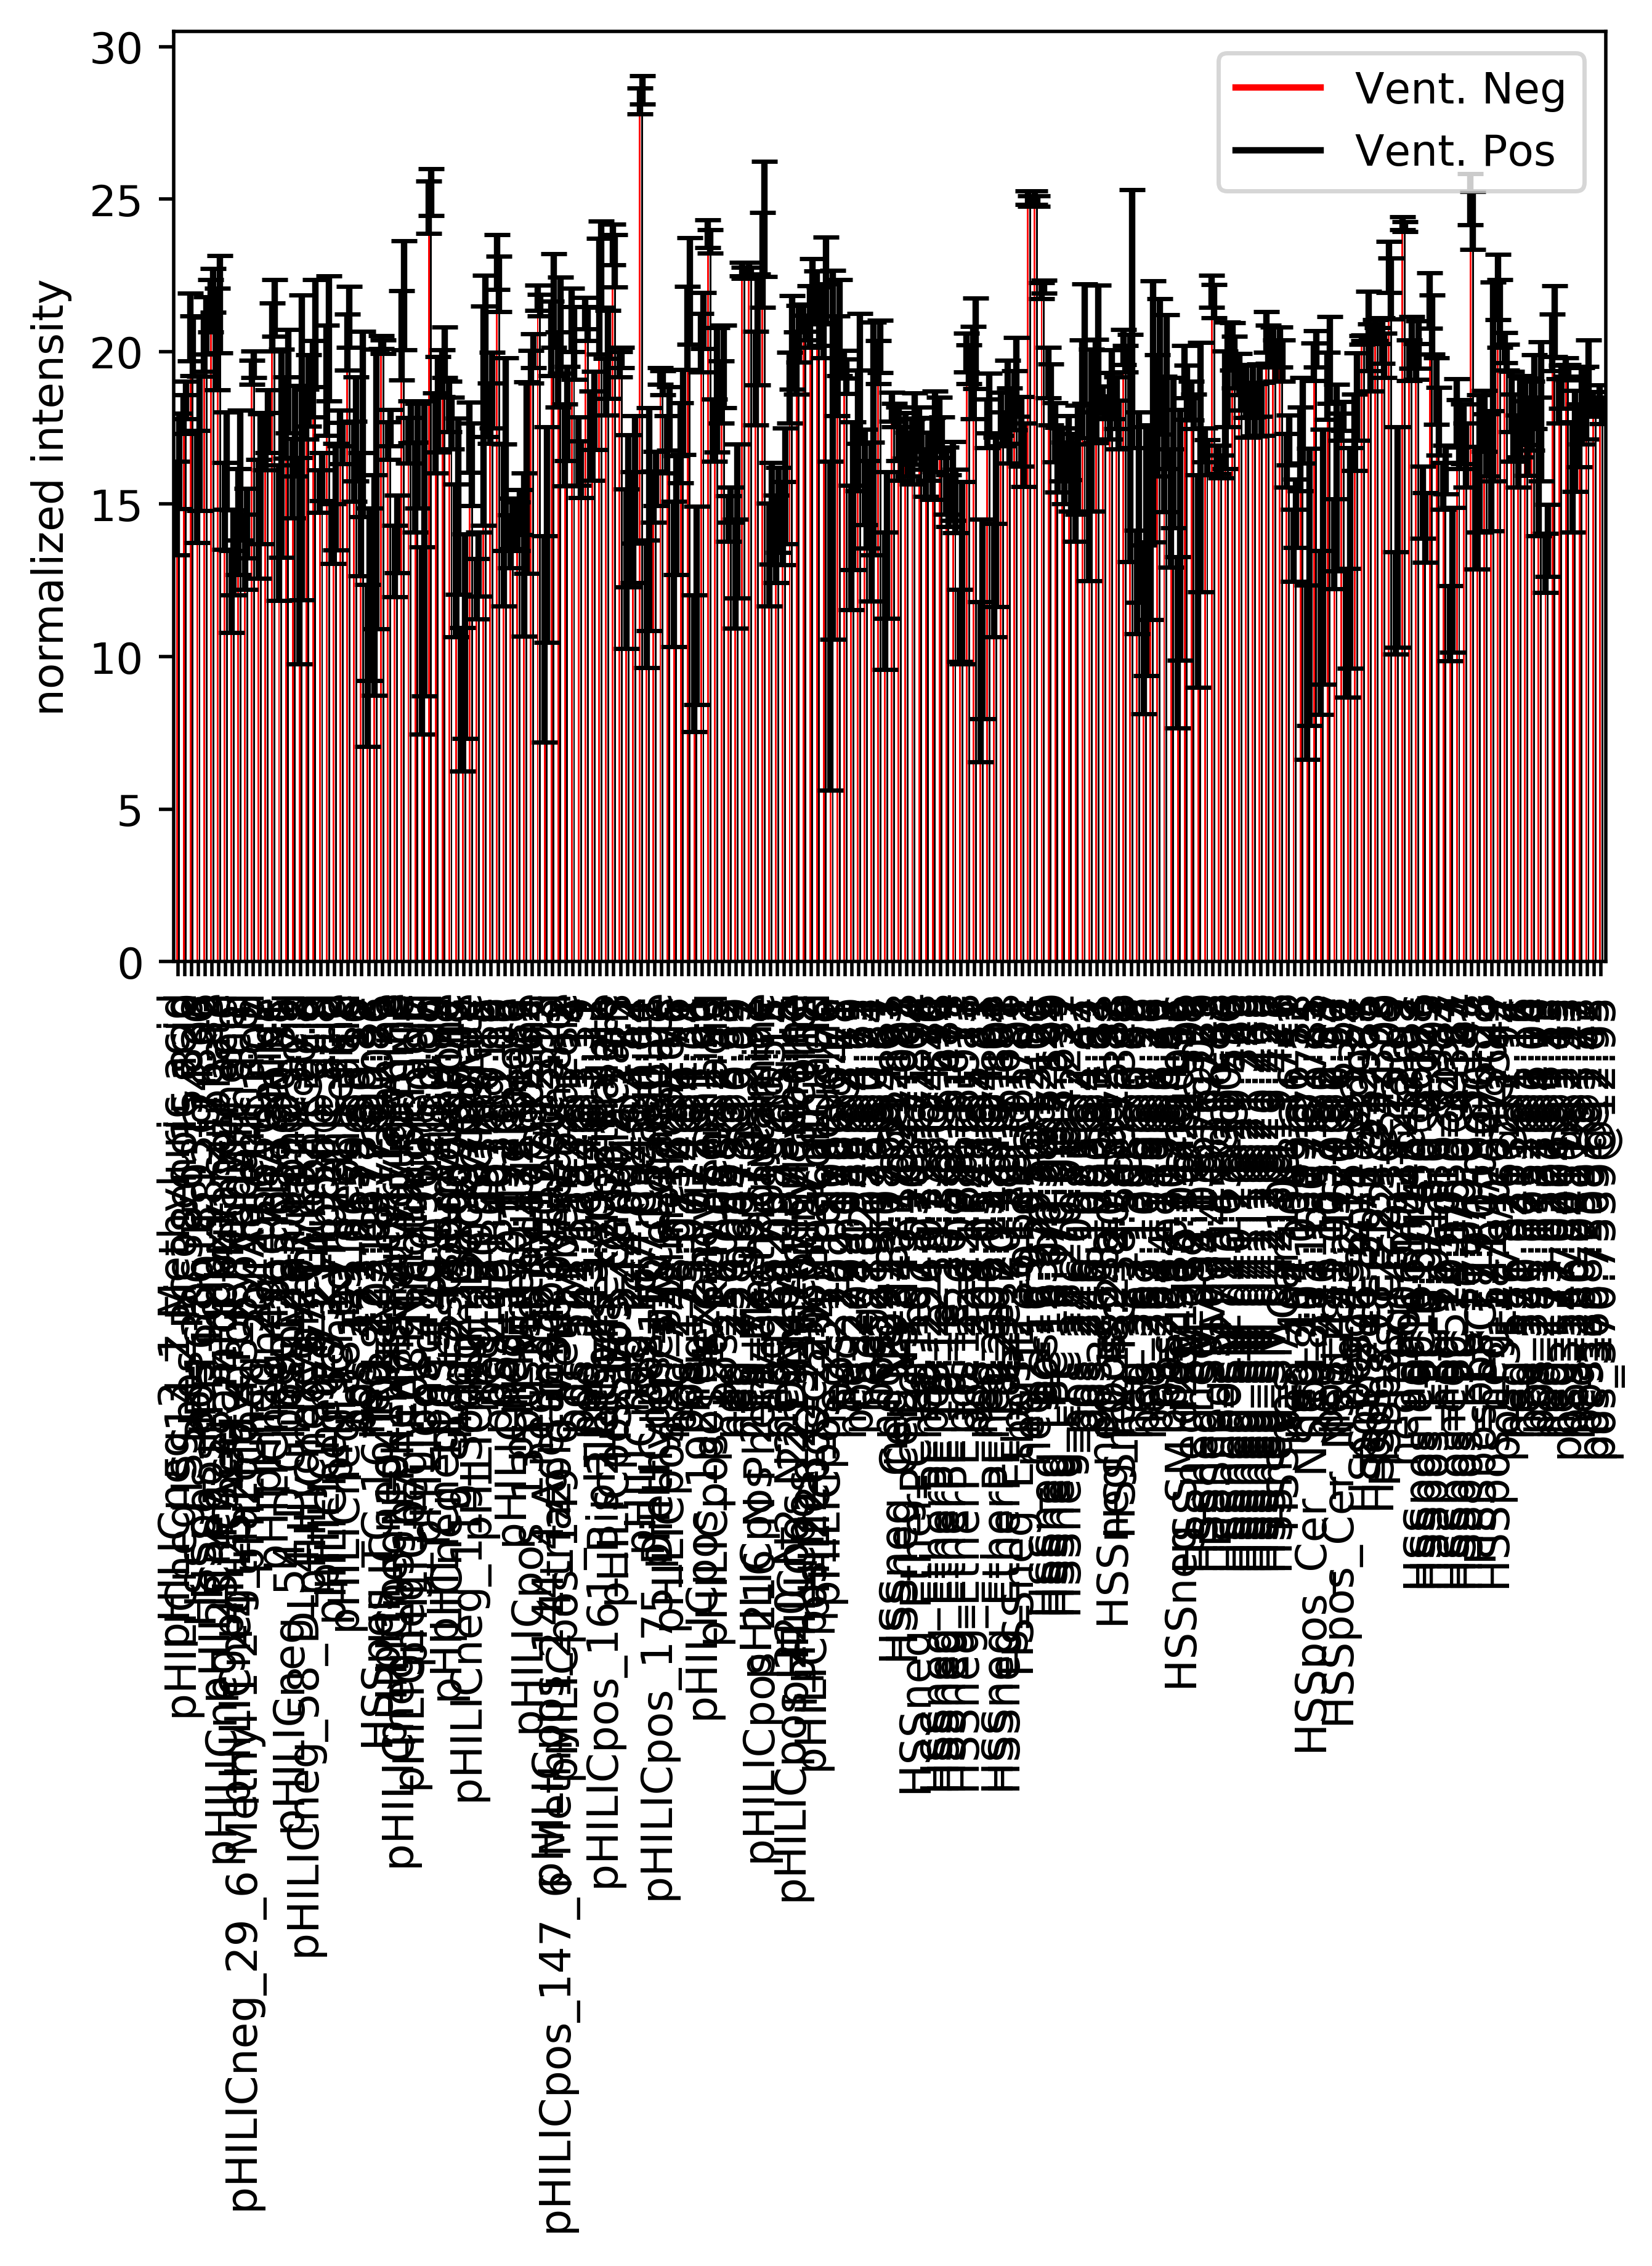

In [15]:
selected_feats = helper.featureSelection(X,y,X_blank,mol_names,["stat",0.05,0],True,True)
